# Behavioral Index to Prove Novelty
1. Template Retrieval

In [1]:
from mylib.statistic_test import *

code_id = '0869 - Detailed Behavioral Analysis'
loc = join(figpath, 'Dsp', code_id)
mkdir(loc)

StatePalette = ["#89d858", "#8b66db", "#5796d5", "#eeb378"]
StatePalette2 = ['#b3d99b', '#d1c8e4', '#a3c1e0', '#ffcc99']
pass

d:\Software\Anaconda3\envs\maze\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


        D:\Data\FinalResults\Dsp\0869 - Detailed Behavioral Analysis is already existed!


# Template Speed

        D:\Data\FinalResults\Dsp\0869 - Detailed Behavioral Analysis\template is already existed!


C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_3332\338538657.py:170: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  sns.lineplot(
C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_3332\338538657.py:187: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  sns.lineplot(
C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_3332\338538657.py:218: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.ecdfplot(


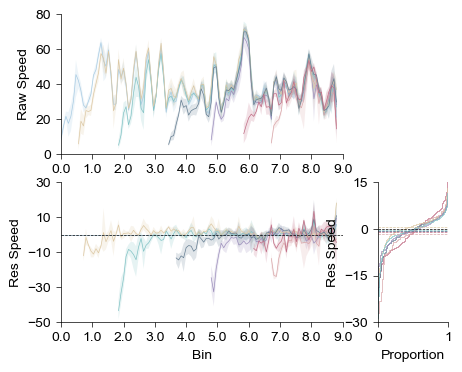

R1: Fr. 2.24  TtestResult(statistic=-1.3354506707981049, pvalue=0.09132324771107546, df=331)
R2: Fr. 5.84  TtestResult(statistic=-1.4195050599775996, pvalue=0.0789133225638575, df=150)
R3: Fr. 7.76  TtestResult(statistic=-1.6491324706724395, pvalue=0.05246337712623422, df=54)
R4: Fr. 0.72  TtestResult(statistic=3.1794746199956547, pvalue=0.999205734220596, df=406)
R5: Fr. 3.84  TtestResult(statistic=-1.6311834985959228, pvalue=0.0520553381411126, df=250)
R6: Fr. 6.16  TtestResult(statistic=-1.5086341574630278, pvalue=0.06687325021801485, df=134)


In [2]:
import scipy.stats

dir_template = join(loc, 'template')
mkdir(dir_template)

def get_median_of_angle(angles):
    """
    Calculate the median of angles in radians.
    """
    # Get the most common angle
    x = np.cos(angles)
    y = np.sin(angles)
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    mean_angle = np.arctan2(y_mean, x_mean)
    
    # Convert angle to be mean_centered
    angles -= mean_angle
    angles[angles < -np.pi] += 2 * np.pi
    angles[angles > np.pi] -= 2 * np.pi
    median_angle = np.median(angles)
    
    # Convert back to original angle
    median_angle += mean_angle
    if median_angle < -np.pi:
        median_angle += 2 * np.pi
    elif median_angle > np.pi:
        median_angle -= 2 * np.pi

    return median_angle

def get_mean_of_angle(angles):
    """
    Calculate the median of angles in radians.
    """
    # Get the most common angle
    x = np.cos(angles)
    y = np.sin(angles)
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    mean_angle = np.arctan2(y_mean, x_mean)
    
    return mean_angle

def generate_template_movement(mouse: int):
    """
    Generate a movement template for a specific mouse at each spatial bin.
    The template is a 4-dimensional vector containing the average position (x, y),
    direction, and speed.
    """
    file_idx = np.where(f2['MiceID'] == mouse)[0]

    templates = np.zeros((144, 4, 7)) # 144 bin, 4-dim vector: position x and y, direction, speed
    behav_vec = [[] for i in range(7)]
    behav_nodes_all = [[] for i in range(7)]
    for i in tqdm(range(7)):
        with open(f2['Trace File'][file_idx[i]], 'rb') as f:
            trace = pickle.load(f)
            
        beg, end = LapSplit(trace, trace['paradigm'])
        routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg)        
        behav_nodes = spike_nodes_transform(trace['correct_nodes'], 12)
        
        for j in range(len(beg)):
            if (trace['is_perfect'][j] == 1 and routes[j] == 0) or (trace['is_perfect'][j] == 1 and routes[j] != 0 and i >= 3):
                dp = np.diff(trace['correct_pos'][beg[j]:end[j], :], axis=0)/10
                dt = np.diff(trace['correct_time'][beg[j]:end[j]])/1000
                dl = np.sqrt(dp[:, 0]**2 + dp[:, 1]**2)
                v = dl / dt
                # Moving Direction
                a = np.arctan2(dp[:, 1], dp[:, 0])
                
                behav_vec[routes[j]].append(np.vstack([
                    trace['correct_pos'][beg[j]:end[j]-1, :].T/10,
                    a,
                    v
                ]))
                behav_nodes_all[routes[j]].append(behav_nodes[beg[j]:end[j]-1])
                
    for i in range(7):         
        behav_vec[i] = np.concatenate(behav_vec[i], axis=1)
        behav_nodes_all[i] = np.concatenate(behav_nodes_all[i])
    
    for r in range(7):
        for b in range(144):
            idx = np.where(behav_nodes_all[r] == b+1)[0]
            if len(idx) > 0:
                templates[b, :, r] = np.median(behav_vec[r][:, idx], axis=1)
                templates[b, 2, r] = get_median_of_angle(behav_vec[r][2, idx])
            else:
                templates[b, :, r] = np.nan
    
    with open(join(dir_template, f'{mouse}.pkl'), 'wb') as f:
        pickle.dump(templates, f)
        
    return templates
"""
generate_template_movement(10212)
generate_template_movement(10224)
generate_template_movement(10227)
generate_template_movement(10232)
"""
def visualize_template(mouse: int, route: int = 0):
    with open(join(dir_template, f"{mouse}.pkl"), 'rb') as f:
        template = pickle.load(f)
    
    fig = plt.figure(figsize=(4, 3))
    ax = Clear_Axes(plt.axes())
    DrawMazeProfile(axes=ax, maze_type=1, color='k', linewidth=0.5)
    qver = ax.quiver(
        template[:, 0, route]/2-0.5, template[:, 1, route]/2-0.5,
        5*np.cos(template[:, 2, route]), -5*np.sin(template[:, 2, route]),
        template[:, 3, route], # color by direction
        cmap='rainbow',
        headwidth=5,
        width=0.006
    )
    ax.invert_yaxis()
    ax.set_aspect('equal')
    plt.colorbar(qver, ax=ax, label='Median Speed (cm/s)')
    plt.tight_layout()
    plt.savefig(join(loc, f'Behav Template [{mouse}].png'), dpi=600)
    plt.savefig(join(loc, f'Behav Template [{mouse}].svg'), dpi=600)
    plt.show()
"""
visualize_template(10212)
visualize_template(10224)
visualize_template(10227)
visualize_template(10232)
"""
if exists(join(figdata, f'{code_id} [Examine Template].pkl')) == False:
    ExTempData = {
        'MiceID': [],
        'Route': [],
        'Bin': [],
        'Raw Speed': [],
        'Res Speed': []
    }
    maze_type = 1
    
    for mouse in [10212, 10224, 10227, 10232]:
        with open(join(dir_template, f"{mouse}.pkl"), 'rb') as f:
            template = pickle.load(f)
            
        for r in range(0, 7):
            raw_speed = template[CP_DSPs[maze_type][r]-1, 3, r]
            res_speed = template[CP_DSPs[maze_type][r]-1, 3, r] - template[CP_DSPs[maze_type][r]-1, 3, 0]
            
            ExTempData['MiceID'].append(np.repeat(mouse, len(raw_speed)))
            ExTempData['Route'].append(np.repeat(r, len(raw_speed)))
            ExTempData['Bin'].append(np.arange(111)[-len(raw_speed):])
            ExTempData['Raw Speed'].append(raw_speed)
            ExTempData['Res Speed'].append(res_speed)
            
    for k in ExTempData.keys():
        ExTempData[k] = np.concatenate(ExTempData[k])
    
    with open(join(figdata, f'{code_id} [Examine Template].pkl'), 'wb') as f:
        pickle.dump(ExTempData, f)
        
    ExTempD = pd.DataFrame(ExTempData)
    ExTempD.to_excel(join(figdata, f'{code_id} [Examine Template].xlsx'), index=False)
    print(len(ExTempD))
else:
    with open(join(figdata, f'{code_id} [Examine Template].pkl'), 'rb') as f:
        ExTempData = pickle.load(f)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 4), gridspec_kw={'width_ratios':[4,1]})
ax0 = Clear_Axes(axes[0, 0], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.lineplot(
    data=ExTempData,
    x='Bin',
    y='Raw Speed',
    hue='Route',
    palette=DSPPalette,
    ax=ax0,
    linewidth=0.5,
    err_kws={'edgecolor': None},
    legend=False
)
ax0.set_ylim(0, 80)
ax0.set_yticks(np.linspace(0, 80, 5))
ax0.set_xticks(np.linspace(0, 112.5, 10), np.linspace(0, 9, 10))
ax0.set_xlim(0, 112.5)

ax1 = Clear_Axes(axes[1, 0], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.lineplot(
    data=ExTempData,
    x='Bin',
    y='Res Speed',
    hue='Route',
    palette=DSPPalette,
    ax=ax1,
    linewidth=0.5,
    err_kws={'edgecolor': None},
    legend=False
)
ax1.set_ylim(-50, 30)
ax1.set_yticks(np.linspace(-50, 30, 5))
ax1.axhline(0, color='k', linewidth=0.5, linestyle='--')
ax1.set_xticks(np.linspace(0, 112.5, 10), np.linspace(0, 9, 10))
ax1.set_xlim(0, 112.5)

Clear_Axes(axes[0, 1])

init_pos = np.array([0, 28, 73, 97, 9, 48, 77])

SubIdx = np.where(
    ((ExTempData['Route'] == 1) & (ExTempData['Bin'] >= init_pos[1])) |
    ((ExTempData['Route'] == 2) & (ExTempData['Bin'] >= init_pos[2])) |
    ((ExTempData['Route'] == 3) & (ExTempData['Bin'] >= init_pos[3])) |
    ((ExTempData['Route'] == 4) & (ExTempData['Bin'] >= init_pos[4])) |
    ((ExTempData['Route'] == 5) & (ExTempData['Bin'] >= init_pos[5])) |
    ((ExTempData['Route'] == 6) & (ExTempData['Bin'] >= init_pos[6]))
)[0]
SubData = SubDict(ExTempData, ExTempData.keys(), SubIdx)
ax2 = Clear_Axes(axes[1, 1], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.ecdfplot(
    data=SubData,
    y='Res Speed',
    hue='Route',
    palette=DSPPalette[1:],
    ax=ax2,
    linewidth=0.5,
    #bins=40,
    #binrange=(-50, 30),
    #line_kws={'linewidth': 0.5},
    #stat='density', 
    #element="step",
    legend=False,
)
ax2.set_ylim(-30, 15)
ax2.set_yticks(np.linspace(-30, 15, 4))
#ax2.set_xlim(0, 0.06)
#ax2.set_xticks(np.linspace(0, 0.06, 4))
ax2.set_xlim(0, 1)
ax2.set_xticks((0, 1))
for r in range(1, 7):
    res_data = SubData['Res Speed'][(SubData['Route'] == r)&(np.isnan(SubData['Res Speed'])==False)]
    bar = np.mean(res_data)
    ax2.axhline(bar, color=DSPPalette[r], linewidth=0.5, linestyle='--')
ax2.axhline(0, color='k', linewidth=0.5, linestyle='--')
plt.savefig(join(loc, f'Examine Template.png'), dpi=600)
plt.savefig(join(loc, f'Examine Template.svg'), dpi=600)
plt.show()

init_m = init_pos/12.5
for r in range(1, 7):
    idx = np.where((ExTempData['Route'] == r)&(np.isnan(ExTempData['Res Speed']) == False)&(ExTempData['Bin']>=init_pos[r]))[0]
    print(f"R{r}: Fr. {init_m[r]:.2f}  {ttest_1samp(ExTempData['Res Speed'][idx], 0, alternative='less')}")

In [3]:
template_fig_dir = join(loc, "Behavioral Template")
mkdir(template_fig_dir)

def visualize_template_all(mouse: int, route: int = 0):
    with open(join(dir_template, f"{mouse}.pkl"), 'rb') as f:
        template = pickle.load(f)
    
    fig = plt.figure(figsize=(4, 3))
    ax = Clear_Axes(plt.axes())
    DrawMazeProfile(axes=ax, maze_type=1, color='k', linewidth=0.5)
    qver = ax.quiver(
        template[:, 0, route]/2-0.5, template[:, 1, route]/2-0.5,
        5*np.cos(template[:, 2, route]), -5*np.sin(template[:, 2, route]),
        template[:, 3, route], # color by direction
        cmap='rainbow',
        headwidth=5,
        width=0.006
    )
    ax.invert_yaxis()
    ax.set_aspect('equal')
    plt.colorbar(qver, ax=ax, label='Median Speed (cm/s)')
    plt.tight_layout()
    plt.savefig(join(template_fig_dir, f'Behav Template [{mouse} - R{route+1}].png'), dpi=600)
    plt.savefig(join(template_fig_dir, f'Behav Template [{mouse} - R{route+1}].svg'), dpi=600)
    plt.close()
"""
for mouse in [10212, 10224, 10227, 10232]:
    for r in tqdm(range(7)):
        visualize_template_all(mouse, r)
"""
pass

        D:\Data\FinalResults\Dsp\0869 - Detailed Behavioral Analysis\Behavioral Template is already existed!


# Template Direction

C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_3332\2981657487.py:44: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  sns.lineplot(
C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_3332\2981657487.py:62: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  sns.lineplot(
C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_3332\2981657487.py:82: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.ecdfplot(


R1: 6.89 deg
R2: 7.66 deg
R3: 19.88 deg
R4: 7.13 deg
R5: 8.55 deg
R6: 20.66 deg


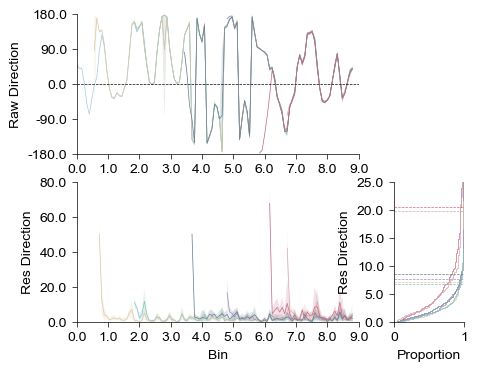

R2 vs R3: KS Statistic = 0.0914, p-value = 0.2154324963966483
R2 vs R5: KS Statistic = 0.0837, p-value = 0.1322608980348691
R2 vs R6: KS Statistic = 0.1261, p-value = 0.015508154591271741
R3 vs R5: KS Statistic = 0.1013, p-value = 0.1157198967549641
R3 vs R6: KS Statistic = 0.0825, p-value = 0.3931460307171087
R5 vs R6: KS Statistic = 0.1534, p-value = 0.001020432362591438

 R4 vs. R7,  KstestResult(statistic=0.07587400484596746, pvalue=0.8469459469732921, statistic_location=0.02662037698020403, statistic_sign=-1)

R2 vs R4: KS Statistic = 0.2944, p-value = 8.643336116551827e-07
R2 vs R7: KS Statistic = 0.3169, p-value = 3.4500248283957596e-09
R3 vs R4: KS Statistic = 0.2753, p-value = 3.491887310168315e-05
R3 vs R7: KS Statistic = 0.2850, p-value = 2.495350724146223e-06
R5 vs R4: KS Statistic = 0.3276, p-value = 1.3930750080161447e-08
R5 vs R7: KS Statistic = 0.3098, p-value = 4.27714236075727e-09
R6 vs R4: KS Statistic = 0.2248, p-value = 0.0007562056490241963
R6 vs R7: KS Statistic 

In [4]:
if exists(join(figdata, f'{code_id} [Examine Template Direction].pkl')) == False:
    ExTempDirData = {
        'MiceID': [],
        'Route': [],
        'Bin': [],
        'Raw Direction': [],
        'Res Direction': []
    }
    
    for mouse in [10212, 10224, 10227, 10232]:
        with open(join(dir_template, f"{mouse}.pkl"), 'rb') as f:
            template = pickle.load(f)
        
        maze_type = 1
            
        for r in range(0, 7):
            raw_direction = template[CP_DSPs[maze_type][r]-1, 2, r]
            res_direction = template[CP_DSPs[maze_type][r]-1, 2, r] - template[CP_DSPs[maze_type][r]-1, 2, 0]
            res_direction[res_direction > np.pi] = 2*np.pi - res_direction[res_direction > np.pi]
            res_direction[res_direction < -np.pi] = -2*np.pi - res_direction[res_direction < -np.pi]
            res_direction = np.abs(res_direction)

            ExTempDirData['MiceID'].append(np.repeat(mouse, len(raw_direction)))
            ExTempDirData['Route'].append(np.repeat(r, len(raw_direction)))
            ExTempDirData['Bin'].append(np.arange(111)[-len(raw_direction):])
            ExTempDirData['Raw Direction'].append(raw_direction)
            ExTempDirData['Res Direction'].append(res_direction)

    for k in ExTempDirData.keys():
        ExTempDirData[k] = np.concatenate(ExTempDirData[k])

    with open(join(figdata, f'{code_id} [Examine Template Direction].pkl'), 'wb') as f:
        pickle.dump(ExTempDirData, f)

    ExTempDirD = pd.DataFrame(ExTempDirData)
    ExTempDirD.to_excel(join(figdata, f'{code_id} [Examine Template Direction].xlsx'), index=False)
    print(len(ExTempDirD))
else:
    with open(join(figdata, f'{code_id} [Examine Template Direction].pkl'), 'rb') as f:
        ExTempDirData = pickle.load(f)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 4), gridspec_kw={'width_ratios':[4,1]})
ax0 = Clear_Axes(axes[0, 0], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.lineplot(
    data=ExTempDirData,
    x='Bin',
    y='Raw Direction',
    hue='Route',
    palette=DSPPalette,
    ax=ax0,
    linewidth=0.5,
    err_kws={'edgecolor': None},
    legend=False
)
ax0.set_ylim(-np.pi, np.pi)
ax0.set_yticks(np.linspace(-np.pi, np.pi, 5), np.linspace(-180, 180, 5))
ax0.axhline(0, color='k', linewidth=0.5, linestyle='--')
ax0.set_xticks(np.linspace(0, 112.5, 10), np.linspace(0, 9, 10))
ax0.set_xlim(0, 112.5)

ax1 = Clear_Axes(axes[1, 0], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.lineplot(
    data=ExTempDirData,
    x='Bin',
    y='Res Direction',
    hue='Route',
    palette=DSPPalette,
    ax=ax1,
    linewidth=0.5,
    err_kws={'edgecolor': None},
    legend=False
)
ax1.set_ylim(0, np.pi*4/9)
ax1.set_yticks(np.linspace(0, np.pi*4/9, 5), np.linspace(0, 80, 5))
ax1.set_xticks(np.linspace(0, 112.5, 10), np.linspace(0, 9, 10))
ax1.set_xlim(0, 112.5)

Clear_Axes(axes[0, 1])

ax2 = Clear_Axes(axes[1, 1], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
SubData = SubDict(ExTempDirData, ExTempDirData.keys(), np.where(ExTempDirData['Route'] != 0)[0])
sns.ecdfplot(
    data=SubData,
    y='Res Direction',
    hue='Route',
    palette=DSPPalette[1:],
    ax=ax2,
    linewidth=0.5,
    #line_kws={'linewidth': 0.5},
    legend=False
)
reses = []
for r in range(1, 7):
    res_dir = SubData['Res Direction'][(SubData['Route'] == r)&(np.isnan(SubData['Res Direction']) == False)]
    bar = np.percentile(res_dir, 95)
    ax2.axhline(bar, color=DSPPalette[r], linewidth=0.5, linestyle='--')
    print(f"R{r}: {np.rad2deg(bar):.2f} deg")
    reses.append(res_dir)
ax2.set_ylim(0, np.pi*1/9*1.25)
ax2.set_yticks(np.linspace(0, np.pi*1/9*1.25, 6), np.linspace(0, 25, 6))
ax2.set_xlim(0, 1)
plt.savefig(join(loc, f'Examine Template Direction.png'), dpi=600)

plt.savefig(join(loc, f'Examine Template Direction.svg'), dpi=600)
plt.show()

# Pairwise KS test
for r1 in [1, 2, 4, 5]:
    for r2 in [1, 2, 4, 5]:
        if r1 >= r2:
            continue
        res_dir1 = reses[r1-1]
        res_dir2 = reses[r2-1]
        ks_stat, p_value = scipy.stats.ks_2samp(res_dir1, res_dir2)
        print(f"R{r1+1} vs R{r2+1}: KS Statistic = {ks_stat:.4f}, p-value = {p_value}")
        
print(f"\n R4 vs. R7,  {scipy.stats.ks_2samp(reses[2], reses[5])}\n")

for r1 in [1, 2, 4, 5]:
    for r2 in [3, 6]:
        res_dir1 = reses[r1-1]
        res_dir2 = reses[r2-1]
        ks_stat, p_value = scipy.stats.ks_2samp(res_dir1, res_dir2)
        print(f"R{r1+1} vs R{r2+1}: KS Statistic = {ks_stat:.4f}, p-value = {p_value}")

# Consistency of Behavioral Template

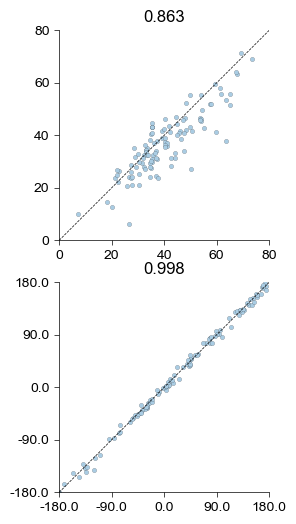

1


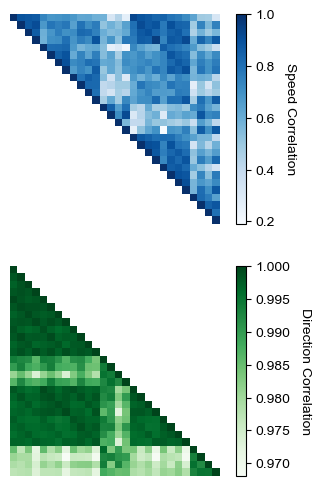

In [5]:
with open(join(dir_template, '10232.pkl'), 'rb') as handle:
    template32 = pickle.load(handle)
    
with open(join(dir_template, '10227.pkl'), 'rb') as handle:
    template27 = pickle.load(handle)
maze_type = 1
dtheta = template32[CP_DSPs[maze_type][0][:-1]-1, 2, 0] - template27[CP_DSPs[maze_type][0][:-1]-1, 2, 0]
x = cp.deepcopy(template32[CP_DSPs[maze_type][0][:-1]-1, 2, 0])
y = cp.deepcopy(template27[CP_DSPs[maze_type][0][:-1]-1, 2, 0])
x[dtheta > np.pi] -= 2*np.pi
x[dtheta < - np.pi] += 2*np.pi

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(3, 6))
ax0 = Clear_Axes(axes[0], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
ax0.scatter(
    template32[CP_DSPs[maze_type][0]-1, 3, 0],
    template27[CP_DSPs[maze_type][0]-1, 3, 0],
    c=DSPPalette[0],
    s=10,
    edgecolors='k',
    linewidths=0.1,
)
ax0.axis([0, 80, 0, 80])
ax0.set_aspect('equal')
ax0.set_xticks(np.linspace(0, 80, 5))
ax0.set_yticks(np.linspace(0, 80, 5))
ax0.plot([0, 80], [0, 80], color='k', linewidth=0.5, linestyle='--')
ax0.set_title(f"{pearsonr(template32[CP_DSPs[maze_type][0]-1, 3, 0], template27[CP_DSPs[maze_type][0]-1, 3, 0])[0]:.3f}")
ax1 = Clear_Axes(axes[1], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
ax1.scatter(
    x, y,
    c=DSPPalette[0],
    s=10,
    edgecolors='k',
    linewidths=0.1,
)
ax1.axis([-np.pi, np.pi, -np.pi, np.pi])
ax1.set_aspect('equal')
ax1.set_xticks(np.linspace(-np.pi, np.pi, 5), np.linspace(-180, 180, 5))
ax1.set_yticks(np.linspace(-np.pi, np.pi, 5), np.linspace(-180, 180, 5))
ax1.plot([-np.pi, np.pi], [-np.pi, np.pi], color='k', linewidth=0.5, linestyle='--')
ax1.set_title(f"{pearsonr(x, y)[0]:.3f}")
plt.savefig(join(loc, f"Template Consistency [32 vs. 27 Example].png"))
plt.savefig(join(loc, f"Template Consistency [32 vs. 27 Example].svg"))
plt.show()

if exists(join(figdata, f"{code_id}  [Template Consistency].pkl")) == False:
    SpeedCorrMat = np.zeros((4*7, 4*7), np.float64) * np.nan
    DirCorrMat = np.zeros((4*7, 4*7), np.float64) * np.nan
    print(1)
    template_set = []
    for mouse in [10212, 10224, 10227, 10232]:
        with open(join(dir_template, f"{mouse}.pkl"), 'rb') as f:
            template = pickle.load(f)
        
        template_set.append(template)
        
    for ri in range(7):
        for rj in range(ri, 7):
            intersected_bins = np.intersect1d(CP_DSPs[maze_type][ri], CP_DSPs[maze_type][rj])
            res_speed = np.zeros((4, 4), np.float64) * np.nan
            res_angle = np.zeros((4, 4), np.float64) * np.nan
            for i in range(4):
                for j in range(4):
                    # Remove the last bin as sometimes there're no data for that bin
                    # such that the correlation is nan.
                    res_speed[i, j] = np.corrcoef(
                        template_set[i][intersected_bins[:-1]-1, 3, ri],
                        template_set[j][intersected_bins[:-1]-1, 3, rj]
                    )[0, 1]
                    
                    dtheta = template_set[i][intersected_bins[:-1]-1, 2, ri] - template_set[j][intersected_bins[:-1]-1, 2, rj]
                    x = cp.deepcopy(template_set[i][intersected_bins[:-1]-1, 2, ri])
                    y = cp.deepcopy(template_set[j][intersected_bins[:-1]-1, 2, rj])
                    x[dtheta > np.pi] -= 2*np.pi
                    x[dtheta < - np.pi] += 2*np.pi
                    
                    res_angle[i, j] = np.corrcoef(x, y)[0, 1]
                    
            if ri == rj:
                res_angle[np.triu_indices(4, 1)] = np.nan
                res_speed[np.tril_indices(4, -1)] = np.nan
                
            SpeedCorrMat[np.ix_(range(ri*4, (ri+1)*4), range(rj*4, (rj+1)*4))] = res_speed    
            DirCorrMat[np.ix_(range(rj*4, (rj+1)*4), range(ri*4, (ri+1)*4))] = res_angle
        
    with open(join(figdata, f"{code_id} [Template Consistency].pkl"), 'wb') as f:
        pickle.dump({ 
            'Speed': SpeedCorrMat,
            'Angle': DirCorrMat
        }, f)
else:
    with open(join(figdata, f"{code_id} [Template Consistency].pkl"), 'rb') as f:
        TemplateConsistency = pickle.load(f)
        SpeedCorrMat = TemplateConsistency['Speed']
        DirCorrMat = TemplateConsistency['Angle']
        
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4, 6))
ax0 = Clear_Axes(axes[0])
im = ax0.imshow(SpeedCorrMat, cmap='Blues', vmax=1)
ax0.set_aspect('equal')
# Add colorbar
cbar = plt.colorbar(im, ax=ax0)
cbar.set_label('Speed Correlation', rotation=270, labelpad=15)

ax1 = Clear_Axes(axes[1])
im = ax1.imshow(DirCorrMat, cmap='Greens', vmax=1)
ax1.set_aspect('equal')
# Add colorbar
cbar = plt.colorbar(im, ax=ax1)
cbar.set_label('Direction Correlation', rotation=270, labelpad=15)
plt.savefig(join(loc, f"Template Consistency.png"), dpi=600)
plt.savefig(join(loc, f"Template Consistency.svg"), dpi=600)
plt.show()

C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_3332\3913349603.py:49: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  box = sns.boxplot(


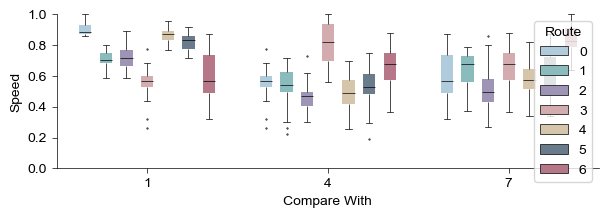

Statistic Test For Speed --------------------------
  Compared with R1:
    R2 vs. R4: TtestResult(statistic=5.143638589699623, pvalue=0.0001200446626051773, df=15)
    R2 vs. R7: TtestResult(statistic=3.2608102681463387, pvalue=0.0052653615991382925, df=15)

    R3 vs. R4: TtestResult(statistic=8.96203360749143, pvalue=2.0703905055128483e-07, df=15)
    R3 vs. R7: TtestResult(statistic=4.367958540091608, pvalue=0.000551189472896697, df=15)

    R5 vs. R4: TtestResult(statistic=10.224732673900744, pvalue=3.727091839750886e-08, df=15)
    R5 vs. R7: TtestResult(statistic=7.89803417735564, pvalue=1.0081015839824124e-06, df=15)

    R6 vs. R4: TtestResult(statistic=11.15121475005677, pvalue=1.1701694506258708e-08, df=15)
    R6 vs. R7: TtestResult(statistic=7.900564021399298, pvalue=1.0041510862950687e-06, df=15)

  Compared with R4:
    R1 vs. R7: TtestResult(statistic=-3.666389597125026, pvalue=0.0022915679385970304, df=15)
    R2 vs. R7: TtestResult(statistic=-4.438342121384043, pvalue

C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_3332\3913349603.py:102: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  box = sns.boxplot(


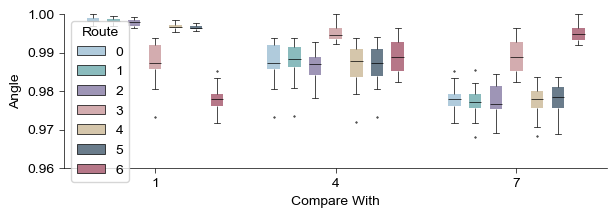



Statistic Test For Angles --------------------------
  Compared with R1:
    R2 vs. R4: TtestResult(statistic=8.391930845559633, pvalue=4.754530151230829e-07, df=15)
    R2 vs. R7: TtestResult(statistic=22.021575275415017, pvalue=7.78441281971478e-13, df=15)

    R3 vs. R4: TtestResult(statistic=8.105508128540446, pvalue=7.325020467109355e-07, df=15)
    R3 vs. R7: TtestResult(statistic=21.312092588514858, pvalue=1.2541210277904347e-12, df=15)

    R5 vs. R4: TtestResult(statistic=7.290281774235373, pvalue=2.6512846784870677e-06, df=15)
    R5 vs. R7: TtestResult(statistic=20.862901923243285, pvalue=1.7094113616776587e-12, df=15)

    R6 vs. R4: TtestResult(statistic=6.839381500517367, pvalue=5.6060556306629504e-06, df=15)
    R6 vs. R7: TtestResult(statistic=20.74164355762601, pvalue=1.8604680490362737e-12, df=15)

  Compared with R4:
    R1 vs. R7: TtestResult(statistic=-1.0053022165097343, pvalue=0.3306939560255283, df=15)
    R2 vs. R7: TtestResult(statistic=-0.6752416607344578, 

In [6]:
if exists(join(figdata, f"{code_id} [Template Consistency Statistics].pkl")) == False:
    TemplateSimilarity = {
        'Speed': [],
        'Angle': [],
        'Route': [],
        'Compare With': [],
    }
    
    R0 = cp.deepcopy(SpeedCorrMat)
    R1 = cp.deepcopy(DirCorrMat)
    R0[np.isnan(R0)] = 0
    R1[np.isnan(R1)] = 0
    R0 = R0 + R0.T
    R1 = R1 + R1.T
    np.fill_diagonal(R0, 1)
    np.fill_diagonal(R1, 1)
    
    for r in range(7):
        TemplateSimilarity['Route'].append(np.repeat(r, 4*4))
        TemplateSimilarity['Compare With'].append(np.repeat(1, 16))
        TemplateSimilarity['Speed'].append(R0[r*4:(r+1)*4, :4].flatten())
        TemplateSimilarity['Angle'].append(R1[:4, r*4:(r+1)*4].flatten())
        
        TemplateSimilarity['Route'].append(np.repeat(r, 4*4))
        TemplateSimilarity['Compare With'].append(np.repeat(4, 16))
        TemplateSimilarity['Speed'].append(R0[r*4:(r+1)*4, 4*3:4*4].flatten())
        TemplateSimilarity['Angle'].append(R1[4*3:4*4, r*4:(r+1)*4].flatten())
        
        TemplateSimilarity['Route'].append(np.repeat(r, 4*4))
        TemplateSimilarity['Compare With'].append(np.repeat(7, 16))
        TemplateSimilarity['Speed'].append(R0[r*4:(r+1)*4, 4*6:4*7].flatten())
        TemplateSimilarity['Angle'].append(R1[4*6:4*7, r*4:(r+1)*4].flatten())

    for k in TemplateSimilarity.keys():
        TemplateSimilarity[k] = np.concatenate(TemplateSimilarity[k])
        
    with open(join(figdata, f"{code_id} [Template Consistency Statistics].pkl"), 'wb') as f:
        pickle.dump(TemplateSimilarity, f)

    TemplateSimilarityD = pd.DataFrame(TemplateSimilarity)
    TemplateSimilarityD.to_excel(join(figdata, f"{code_id} [Template Consistency Statistics].xlsx"), index=False)
    print(len(TemplateSimilarityD))
else:
    with open(join(figdata, f"{code_id} [Template Consistency Statistics].pkl"), 'rb') as f:
        TemplateSimilarity = pickle.load(f)
        
fig = plt.figure(figsize=(7, 2))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
box = sns.boxplot(
    data=TemplateSimilarity,
    x='Compare With',
    y='Speed',
    hue='Route',
    palette=DSPPalette,
    ax=ax,
    linewidth=0.5,
    linecolor='k',
    fliersize=0.5,
    width=0.8,
    gap=0.4
)
for b in box.patches:
    b.set_linewidth(0)
ax.set_ylim(0, 1)
ax.set_yticks(np.linspace(0, 1, 6))
plt.savefig(join(loc, f'Template Consistency [Speed].png'), dpi=600)
plt.savefig(join(loc, f'Template Consistency [Speed].svg'), dpi=600)
plt.show()

print("Statistic Test For Speed --------------------------")
print("  Compared with R1:")
for r in range(1, 7):
    if r in [3, 6]:
        continue
    
    idxr = np.where((TemplateSimilarity['Route'] == r) & (TemplateSimilarity['Compare With'] == 1))[0]
    idx4 = np.where((TemplateSimilarity['Route'] == 3) & (TemplateSimilarity['Compare With'] == 1))[0]
    idx7 = np.where((TemplateSimilarity['Route'] == 6) & (TemplateSimilarity['Compare With'] == 1))[0]
    print(f"    R{r+1} vs. R4: {ttest_rel(TemplateSimilarity['Speed'][idxr], TemplateSimilarity['Speed'][idx4])}")
    print(f"    R{r+1} vs. R7: {ttest_rel(TemplateSimilarity['Speed'][idxr], TemplateSimilarity['Speed'][idx7])}\n")
    
print("  Compared with R4:")
for r in range(7):
    if r in [3, 6]:
        continue

    idxr = np.where((TemplateSimilarity['Route'] == r) & (TemplateSimilarity['Compare With'] == 4))[0]
    idx7 = np.where((TemplateSimilarity['Route'] == 6) & (TemplateSimilarity['Compare With'] == 4))[0]
    print(f"    R{r+1} vs. R7: {ttest_rel(TemplateSimilarity['Speed'][idxr], TemplateSimilarity['Speed'][idx7])}")

print("  Compared with R7:")
for r in range(7):
    if r in [3, 6]:
        continue

    idxr = np.where((TemplateSimilarity['Route'] == r) & (TemplateSimilarity['Compare With'] == 7))[0]
    idx4 = np.where((TemplateSimilarity['Route'] == 3) & (TemplateSimilarity['Compare With'] == 7))[0]
    print(f"    R{r+1} vs. R7: {ttest_rel(TemplateSimilarity['Speed'][idxr], TemplateSimilarity['Speed'][idx4])}")

fig = plt.figure(figsize=(7, 2))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
box = sns.boxplot(
    data=TemplateSimilarity,
    x='Compare With',
    y='Angle',
    hue='Route',
    palette=DSPPalette,
    ax=ax,
    linewidth=0.5,
    linecolor='k',
    fliersize=0.5,
    width=0.8,
    gap=0.4
)
for b in box.patches:
    b.set_linewidth(0)
ax.set_ylim(0.96, 1)
plt.savefig(join(loc, f'Template Consistency [Direction].png'), dpi=600)
plt.savefig(join(loc, f'Template Consistency [Direction].svg'), dpi=600)
plt.show()

print("\n\nStatistic Test For Angles --------------------------")
print("  Compared with R1:")
for r in range(1, 7):
    if r in [3, 6]:
        continue
    
    idxr = np.where((TemplateSimilarity['Route'] == r) & (TemplateSimilarity['Compare With'] == 1))[0]
    idx4 = np.where((TemplateSimilarity['Route'] == 3) & (TemplateSimilarity['Compare With'] == 1))[0]
    idx7 = np.where((TemplateSimilarity['Route'] == 6) & (TemplateSimilarity['Compare With'] == 1))[0]
    print(f"    R{r+1} vs. R4: {ttest_rel(TemplateSimilarity['Angle'][idxr], TemplateSimilarity['Angle'][idx4])}")
    print(f"    R{r+1} vs. R7: {ttest_rel(TemplateSimilarity['Angle'][idxr], TemplateSimilarity['Angle'][idx7])}\n")

print("  Compared with R4:")
for r in range(7):
    if r in [3, 6]:
        continue

    idxr = np.where((TemplateSimilarity['Route'] == r) & (TemplateSimilarity['Compare With'] == 4))[0]
    idx7 = np.where((TemplateSimilarity['Route'] == 6) & (TemplateSimilarity['Compare With'] == 4))[0]
    print(f"    R{r+1} vs. R7: {ttest_rel(TemplateSimilarity['Angle'][idxr], TemplateSimilarity['Angle'][idx7])}")

print("  Compared with R7:")
for r in range(7):
    if r in [3, 6]:
        continue

    idxr = np.where((TemplateSimilarity['Route'] == r) & (TemplateSimilarity['Compare With'] == 7))[0]
    idx4 = np.where((TemplateSimilarity['Route'] == 3) & (TemplateSimilarity['Compare With'] == 7))[0]
    print(f"    R{r+1} vs. R7: {ttest_rel(TemplateSimilarity['Angle'][idxr], TemplateSimilarity['Angle'][idx4])}")

In [7]:
# Diagonal Correlation
speed_diagonal = np.concatenate([
    SpeedCorrMat[np.ix_(np.arange(i*4, (i+1)*4), np.arange(i*4, (i+1)*4))][np.triu_indices(4, k=1)]for i in range(7)
])
angle_diagonal = np.concatenate([
    DirCorrMat[np.ix_(np.arange(i*4, (i+1)*4), np.arange(i*4, (i+1)*4))][np.tril_indices(4, k=-1)]for i in range(7)
])
print_estimator(speed_diagonal)
print_estimator(angle_diagonal)

  Mean: 0.8323768837464613, STD: 0.07459298837482667, Max: 0.9176647738207345, Min: 0.5613672882291395, Median: 0.8472748007894922, df: 41
  Mean: 0.9967109450085168, STD: 0.0019542664774872486, Max: 0.9990913268957585, Min: 0.9921255789217077, Median: 0.9975562552149286, df: 41


# Examine Behavioral Retrieval with HMM

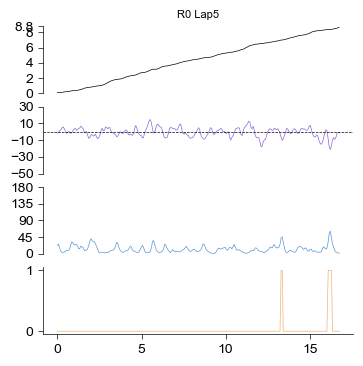

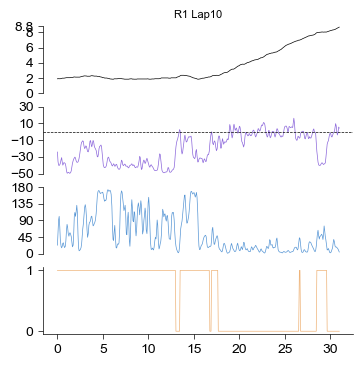

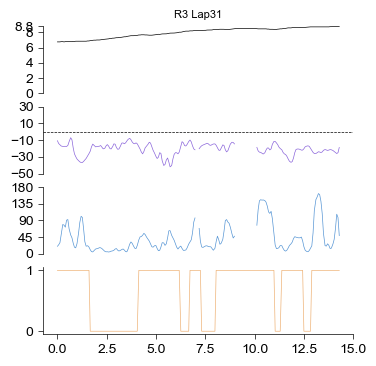

In [8]:
# Hidden Markov Model
import numpy as np
from hmmlearn.hmm import GaussianHMM

def get_hmm_states(
    behav_res_angles: np.ndarray, 
    behav_res_speeds: np.ndarray, 
    behav_speed_traj: np.ndarray,
    behav_lap_traj: np.ndarray
):
    """Use HMM to get behavioral states."""
    # Example data: 1D oscillatory behavior (you may have more features in real data)
    # Simulate some example data: 2 states with different distributions
    # Data: N time steps, observed as 1D feature (you can replace this with real data)

    behav_hidden_states = np.ones_like(behav_res_angles)
    
    observations = np.vstack([
        behav_res_angles,
        behav_res_speeds#,
        #behav_speed_traj
    ]).T

    fit_idx = np.where(
        (np.isnan(observations[:, 0]) == False) &
        (np.isnan(observations[:, 1]) == False)# &
        #(np.isnan(behav_speed_traj) == False)
    )[0]
    observations = observations[fit_idx, :]

    fit_lap_traj = behav_lap_traj[fit_idx]
    beg = np.concatenate([[0], np.where(np.diff(fit_lap_traj) != 0)[0] + 1])
    end = np.concatenate([np.where(np.diff(fit_lap_traj) != 0)[0]+1, [len(fit_lap_traj)]])
    lengths = end-beg

    # Define the number of hidden states (2 states for low and high amplitude)
    model = GaussianHMM(n_components=2, covariance_type="diag", n_iter=1000, random_state=42)

    # Train the model using the Baum-Welch algorithm (unsupervised)
    model.fit(observations, lengths=lengths)

    # Predict the hidden states for each time point
    hidden_states = model.predict(observations, lengths=lengths)
    
    idx0 = np.where(hidden_states == 0)[0]
    idx1 = np.where(hidden_states == 1)[0]
    
    res0 = np.nanmean(behav_res_angles[fit_idx][idx0])
    res1 = np.nanmean(behav_res_angles[fit_idx][idx1])
    if res0 > res1:
        behav_hidden_states[fit_idx] = 1 - hidden_states
    else:
        behav_hidden_states[fit_idx] = hidden_states
    return behav_hidden_states

def behavioral_template_retrieval(mouse: int, session: int, maze_type: int):
    with open(join(dir_template, f"{mouse}.pkl"), 'rb') as f:
        template = pickle.load(f)
        
    file_idx = np.where(f2['MiceID'] == mouse)[0][session]
    
    with open(f2['Trace File'][file_idx], 'rb') as f:
        trace = pickle.load(f)
        
    beg, end = LapSplit(trace, trace['paradigm'])
    routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg, maze_type=maze_type)
    behav_nodes = spike_nodes_transform(trace['correct_nodes'], 12)
    
    behav_nodes_traj = []
    behav_nodes_son_traj = []
    behav_lap_traj = []
    behav_routes_traj = []
    behav_session_traj = []
    behav_params_traj = []
    behav_params_templ_traj = []
    behav_dt_traj = []
    behav_t_traj = []


    for j in range(len(beg)):
        dp = np.diff(trace['correct_pos'][beg[j]:end[j], :], axis=0)/10
        dt = np.diff(trace['correct_time'][beg[j]:end[j]])/1000
        dl = np.sqrt(dp[:, 0]**2 + dp[:, 1]**2)
        v = dl/dt
        # Moving Direction
        a = np.arctan2(dp[:, 1], dp[:, 0])
        
        params = np.vstack([
            trace['correct_pos'][beg[j]:end[j]-1, :].T/10,
            a,
            v
        ])
        params_templ = template[behav_nodes[beg[j]:end[j]-1]-1, :, 0].T
        
        behav_nodes_traj.append(behav_nodes[beg[j]:end[j]-1])
        behav_nodes_son_traj.append(trace['correct_nodes'][beg[j]:end[j]-1])
        behav_lap_traj.append(np.repeat(j, len(params[0])))
        behav_routes_traj.append(np.repeat(routes[j], len(params[0])))
        behav_session_traj.append(np.repeat(session, len(params[0])))
        behav_params_traj.append(params)
        behav_params_templ_traj.append(params_templ)
        behav_dt_traj.append(dt)
        behav_t_traj.append((trace['correct_time'][beg[j]:end[j]-1] - trace['correct_time'][beg[j]])/1000)
        
    behav_nodes_traj = np.concatenate(behav_nodes_traj)
    incorrect_path_idx = np.where(np.isin(behav_nodes_traj, CP_DSPs[maze_type][0]) == False)[0]
    behav_nodes_son_traj = np.concatenate(behav_nodes_son_traj)
    behav_lap_traj = np.concatenate(behav_lap_traj)
    behav_routes_traj = np.concatenate(behav_routes_traj)
    behav_session_traj = np.concatenate(behav_session_traj)
    behav_params_traj = np.concatenate(behav_params_traj, axis=1)
    behav_params_templ_traj = np.concatenate(behav_params_templ_traj, axis=1)
    behav_dt_traj = np.concatenate(behav_dt_traj)
    behav_t_traj = np.concatenate(behav_t_traj)

    behav_res_angles = behav_params_traj[2, :] - behav_params_templ_traj[2, :]
    behav_res_angles[behav_res_angles > np.pi] = 2*np.pi - behav_res_angles[behav_res_angles > np.pi]
    behav_res_angles[behav_res_angles < -np.pi] = -2*np.pi - behav_res_angles[behav_res_angles < -np.pi]
    behav_res_angles = np.rad2deg(np.abs(behav_res_angles))
    behav_res_speeds = behav_params_traj[3, :] - behav_params_templ_traj[3, :]

    def gaussian_kernel(x, sigma):
        return np.exp(-x**2/(2*sigma**2))/(sigma*np.sqrt(2*np.pi))

    # Smooth the residuals within each lap

    beg = np.concatenate([[0], np.where(np.diff(behav_lap_traj) != 0)[0] + 1])
    end = np.concatenate([np.where(np.diff(behav_lap_traj) != 0)[0]+1, [len(behav_lap_traj)]])
    for i in range(len(beg)):
        gkernel = gaussian_kernel(np.linspace(-5, 5, 11), sigma=1)
        gkernel /= np.sum(gkernel)
        nonnan_idx = np.where(np.isnan(behav_res_angles[beg[i]:end[i]]) == False)[0]
        try:
            behav_res_angles[beg[i]:end[i]][nonnan_idx] = np.convolve(behav_res_angles[beg[i]:end[i]][nonnan_idx], gkernel, mode='same')
            behav_res_speeds[beg[i]:end[i]][nonnan_idx] = np.convolve(behav_res_speeds[beg[i]:end[i]][nonnan_idx], gkernel, mode='same')
        except:
            pass

    # Set the incorrect path indices to NaN
    #behav_res_angles[incorrect_path_idx] = np.nan
    #behav_res_speeds[incorrect_path_idx] = np.nan
    
    behav_hidden_states = get_hmm_states(
        behav_res_angles,   
        behav_res_speeds,
        behav_params_traj[3, :],
        behav_lap_traj
    )
    #behav_hidden_states[incorrect_path_idx] = 1
    
    return (
        behav_nodes_traj.astype(np.int64),
        behav_nodes_son_traj.astype(np.int64),
        behav_lap_traj.astype(np.int64),
        behav_routes_traj.astype(np.int64),
        behav_session_traj.astype(np.int64),
        behav_params_traj.astype(np.float64),
        behav_params_templ_traj.astype(np.float64),
        behav_dt_traj.astype(np.float64),
        behav_t_traj.astype(np.float64),
        behav_res_angles.astype(np.float64),
        behav_res_speeds.astype(np.float64),
        behav_hidden_states.astype(np.float64)
   )
    
def get_nontemplate_profile(mouse: int, session: int, maze_type: int) -> np.ndarray:
    (
        behav_nodes_traj,
        behav_nodes_son_traj,
        behav_lap_traj,
        behav_routes_traj,
        behav_session_traj,
        behav_params_traj,
        behav_params_templ_traj,
        behav_dt_traj,
        behav_t_traj
   ) = behavioral_template_retrieval(mouse, session)

    templates = np.zeros((144, 4, 7)) # 144 bin, 4-dim vector: position x and y, direction, speed
    for r in range(7):
        for b in CP_DSPs[maze_type][r]:
            idx = np.where((behav_nodes_traj == b) & (behav_routes_traj == r))[0]
            if len(idx) > 0:
                templates[b-1, :, r] = np.median(behav_params_traj[:, idx], axis=1)
                templates[b-1, 2, r] = get_median_of_angle(behav_params_traj[2, idx])
            else:
                templates[b-1, :, r] = np.nan
                
    return templates

(
        behav_nodes_traj,
        behav_nodes_son_traj,
        behav_lap_traj,
        behav_routes_traj,
        behav_session_traj,
        behav_params_traj,
        behav_params_templ_traj,
        behav_dt_traj,
        behav_t_traj,
        behav_res_angles,
        behav_res_speeds,
        behav_hidden_states
) = behavioral_template_retrieval(10232, 0, 1)

beg = np.concatenate([[0], np.where(np.diff(behav_lap_traj) != 0)[0] + 1])
end = np.concatenate([np.where(np.diff(behav_lap_traj) != 0)[0]+1, [len(behav_lap_traj)]])
D = GetDMatrices(1, 48)
for i in range(len(beg)):
    if i not in [5, 10, 31]:
        continue
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(4, 4))
    x = D[behav_nodes_son_traj[beg[i]:end[i]]-1, 0]/(np.max(D)+1e-8)*111
    ax0 = Clear_Axes(axes[0], close_spines=['top', 'right', 'bottom'], ifxticks=False, ifyticks=True)
    t = behav_t_traj[beg[i]:end[i]]
    ax0.plot(
        t,
        x,
        color='k',
        linewidth=0.5
    )
    xlims = ax0.get_xlim()
    ax0.set_title(f"R{behav_routes_traj[beg[i]]} Lap{behav_lap_traj[beg[i]]}", fontdict={'fontsize': 8})
    ax0.set_ylim(0, 110)
    ax0.set_yticks([0, 25, 50, 75, 100, 110], [0, 2, 4, 6, 8, 8.8])
    
    ax1 = Clear_Axes(axes[1], close_spines=['top', 'right', 'bottom'], ifxticks=False, ifyticks=True)
    ax1.plot(
        t,
        behav_res_speeds[beg[i]:end[i]],
        color=StatePalette[1],
        linewidth=0.5
    )
    ax1.set_ylim(-50, 30)
    ax1.set_yticks(np.linspace(-50, 30, 5))
    ax1.axhline(0, color='k', linewidth=0.5, linestyle='--')
    ax1.set_xlim(xlims)
    
    ax2 = Clear_Axes(axes[2], close_spines=['top', 'right', 'bottom'], ifxticks=False, ifyticks=True)
    ax2.plot(
        t,
        behav_res_angles[beg[i]:end[i]],
        color=StatePalette[2],
        linewidth=0.5
    )
    ax2.set_ylim(0, 180)
    ax2.set_yticks(np.linspace(0, 180, 5))
    ax2.set_xlim(xlims)
    
    ax3 = Clear_Axes(axes[3], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    ax3.plot(
        t,
        behav_hidden_states[beg[i]:end[i]],
        color=StatePalette[3],
        linewidth=0.5
    )
    ax3.set_xlim(xlims)
    plt.savefig(join(loc, f"Example Lap With Behavioral Retrieval [Lap {i+1}, R{behav_routes_traj[beg[i]]+1}].png"), dpi=600)
    plt.savefig(join(loc, f"Example Lap With Behavioral Retrieval [Lap {i+1}, R{behav_routes_traj[beg[i]]+1}].svg"), dpi=600)
    plt.show()


# What HMM States could Inform Us

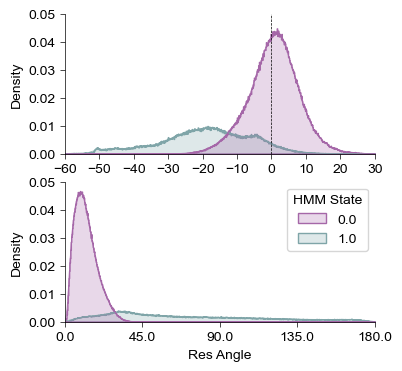

KstestResult(statistic=nan, pvalue=nan, statistic_location=nan, statistic_sign=nan)
KstestResult(statistic=nan, pvalue=nan, statistic_location=nan, statistic_sign=nan)


In [9]:
if exists(join(figdata, f"{code_id} [HMM State Represent].pkl")) == False:
    HMMStateMeaning = {
        'MiceID': [],
        'Session': [],
        'Route': [],
        'Res Speed': [],
        'Res Angle': [],
        'HMM State': []
    }
    
    for mouse in [10212, 10224, 10227, 10232]:
        maze_type = 1
        for session in tqdm(range(7)):
            (
                behav_nodes_traj,
                behav_nodes_son_traj,
                behav_lap_traj,
                behav_routes_traj,
                behav_session_traj,
                behav_params_traj,
                behav_params_templ_traj,
                behav_dt_traj,
                behav_t_traj,
                behav_res_angles,
                behav_res_speeds,
                behav_hidden_states
            ) = behavioral_template_retrieval(mouse, session, maze_type=maze_type)
            
            HMMStateMeaning['MiceID'].append(np.repeat(mouse, len(behav_hidden_states)))
            HMMStateMeaning['Session'].append(np.repeat(session, len(behav_hidden_states)))
            HMMStateMeaning['Route'].append(behav_routes_traj)
            HMMStateMeaning['Res Speed'].append(behav_res_speeds)
            HMMStateMeaning['Res Angle'].append(behav_res_angles)
            HMMStateMeaning['HMM State'].append(behav_hidden_states)
            
    for k in HMMStateMeaning.keys():
        HMMStateMeaning[k] = np.concatenate(HMMStateMeaning[k])
        
    with open(join(figdata, f"{code_id} [HMM State Represent].pkl"), 'wb') as f:
        pickle.dump(HMMStateMeaning, f)
    
    try:
        HMMStateMeaningD = pd.DataFrame(HMMStateMeaning)
        HMMStateMeaningD.to_excel(join(figdata, f"{code_id} [HMM State Represent].xlsx"), index=False)
    except:
        pass
    print(len(HMMStateMeaningD))
else:
    with open(join(figdata, f"{code_id} [HMM State Represent].pkl"), 'rb') as f:
        HMMStateMeaning = pickle.load(f)
        
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4, 4))
ax0 = Clear_Axes(axes[0], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.histplot(
    data=HMMStateMeaning,
    x='Res Speed',
    hue='HMM State',
    palette=['#a567a8', '#7fa5a8'],
    ax=ax0,
    bins=800,
    binrange=(-60, 30),
    stat='density', 
    element="step",
    legend=False,
    kde=True,fill=True,
    line_kws={'linewidth': 0.5}
)
ax0.set_ylim(0, 0.05)
ax0.set_yticks(np.linspace(0, 0.05, 6))
ax0.set_xticks(np.linspace(-60, 30, 10))
ax0.set_xlim(-60, 30)
ax0.axvline(0, color='k', linewidth=0.5, linestyle='--')

ax1 = Clear_Axes(axes[1], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.histplot(
    data=HMMStateMeaning,
    x='Res Angle',
    hue='HMM State',
    palette=['#a567a8', '#7fa5a8'],
    ax=ax1,
    bins=720,
    binrange=(0, 180),
    stat='density', 
    element="step",
    fill=True,
    kde=True,
    line_kws={'linewidth': 0.5}
)
ax1.set_xlim(0, 180)
ax1.set_ylim(0, 0.05)
ax1.set_yticks(np.linspace(0, 0.05, 6))
ax1.set_xticks(np.linspace(0, 180, 5), np.linspace(0, 180, 5))
plt.savefig(join(loc, f"HMM State Represent.png"), dpi=600)
plt.savefig(join(loc, f"HMM State Represent.svg"), dpi=600)
plt.show()

idx0 = np.where(HMMStateMeaning['HMM State'] == 0)[0]
idx1 = np.where(HMMStateMeaning['HMM State'] == 1)[0]

print(ks_2samp(HMMStateMeaning['Res Speed'][idx0], HMMStateMeaning['Res Speed'][idx1]))
print(ks_2samp(HMMStateMeaning['Res Angle'][idx0], HMMStateMeaning['Res Angle'][idx1]))

C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_3332\3130997698.py:100: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  sns.lineplot(


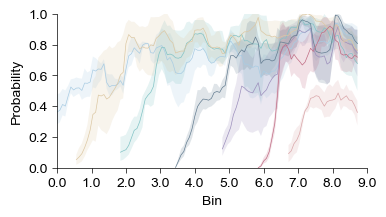

C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_3332\3130997698.py:120: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.lineplot(


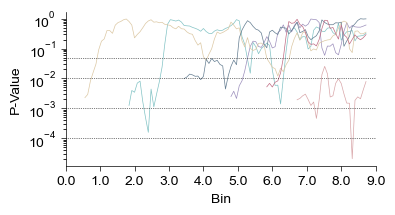

C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_3332\3130997698.py:143: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.lineplot(


'\nSubData = SubDict(HMMStateProb, HMMStateProb.keys(), np.where((HMMStateProb[\'Bin\'] >= 107)|(HMMStateProb[\'Ego Bin\'] <= 2))[0])\nSubData[\'hue\'] = np.where(SubData[\'Ego Bin\'] <= 2, 0, 1)\nfig = plt.figure(figsize=(4, 2))\nax = Clear_Axes(plt.axes(), close_spines=[\'top\', \'right\'], ifxticks=True, ifyticks=True)\nsns.stripplot(\n    x=\'Route\',\n    y=\'Probability\',\n    hue=\'hue\',\n    data=SubData,\n    palette=[sns.color_palette("Greens", 3)[0], sns.color_palette("Blues", 3)[0]],\n    ax=ax,\n    size=7,\n    alpha=0.8,\n    linewidth=0.1,\n    edgecolor=\'k\',\n    legend=False,\n    jitter=0,\n    dodge=True,\n)\ndata0 = []\ndata1 = []\nfor r in range(7):\n    idx0 = np.where((SubData[\'Route\'] == r)&(SubData[\'hue\'] == 0))[0]\n    idx1 = np.where((SubData[\'Route\'] == r)&(SubData[\'hue\'] == 1))[0]\n    for j in range(12):\n        ax.plot([r-0.2, r+0.2], [SubData[\'Probability\'][idx0[j]], SubData[\'Probability\'][idx1[j]]], color=\'k\', linewidth=0.2)\n       

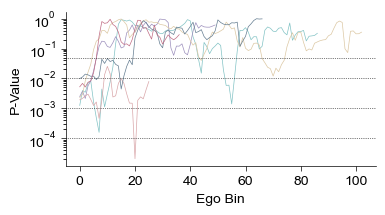

In [ ]:
if exists(join(figdata, f"{code_id} [HMM State Probability Along Track].pkl")) == False:
    HMMStateProb = {
        'MiceID': [],
        'Route': [],
        'Bin': [],
        'Ego Bin': [],
        'HMM State': [],
        'Probability': []
    }
    
    for mouse in [10212, 10224, 10227, 10232]:
        maze_type = 1
        (
            behav_nodes_traj,
            behav_nodes_son_traj,
            behav_lap_traj,
            behav_routes_traj,
            behav_session_traj,
            behav_params_traj,
            behav_params_templ_traj,
            behav_dt_traj,
            behav_t_traj,
            behav_res_angles,
            behav_res_speeds,
            behav_hidden_states
        ) = behavioral_template_retrieval(mouse, session=0, maze_type=maze_type)

        for r in tqdm(range(7)):
            prob = np.zeros((2, CP_DSPs[maze_type][r].shape[0]-1), np.float64)
            for i, b in enumerate(CP_DSPs[maze_type][r][:-1]):
                retrieved_state_idx = np.where((behav_routes_traj == r) & (behav_nodes_traj == b) & (behav_hidden_states == 0))[0]
                other_state_idx = np.where((behav_routes_traj == r) & (behav_nodes_traj == b) & (behav_hidden_states == 1))[0]
                prob[0, i] = np.sum(behav_dt_traj[retrieved_state_idx])
                prob[1, i] = np.sum(behav_dt_traj[other_state_idx])
            
            prob[0, :] = np.convolve(prob[0, :], np.ones(7), mode='same')
            prob[1, :] = np.convolve(prob[1, :], np.ones(7), mode='same')
            prob = prob / np.sum(prob, axis=0)

            _len = prob.shape[1]
            HMMStateProb['MiceID'].append(np.repeat(mouse, prob.shape[1]))
            HMMStateProb['Route'].append(np.repeat(r, prob.shape[1]))
            HMMStateProb['Bin'].append(np.arange(110)[-_len:])
            HMMStateProb['Ego Bin'].append(np.arange(_len))
            HMMStateProb['HMM State'].append(np.repeat(0, prob.shape[1]))
            HMMStateProb['Probability'].append(prob[0, :])

    for k in HMMStateProb.keys():
        HMMStateProb[k] = np.concatenate(HMMStateProb[k])

    with open(join(figdata, f"{code_id} [HMM State Probability Along Track].pkl"), 'wb') as f:
        pickle.dump(HMMStateProb, f)

    try:
        HMMStateProbD = pd.DataFrame(HMMStateProb)
        HMMStateProbD.to_excel(join(figdata, f"{code_id} [HMM State Probability Along Track].xlsx"), index=False)
    except:
        pass
    print(len(HMMStateProbD))
else:
    with open(join(figdata, f"{code_id} [HMM State Probability Along Track].pkl"), 'rb') as f:
        HMMStateProb = pickle.load(f)

if exists(join(figdata, f"{code_id} [HMM State Probability Along Track - Statistics].pkl")) == False:
    HMMStateProbStats = {
        'Route': [],
        'Bin': [],
        'Ego Bin': [],
        'P-Value': []
    }
    
    for r in range(1, 7):
        for b in range(112):
            idx = np.where((HMMStateProb['Route'] == r) & (HMMStateProb['Bin'] == b))[0]
            idx_r0 = np.where((HMMStateProb['Route'] == 0) & (HMMStateProb['Bin'] == b))[0]
            if len(idx) == 0:
                continue
            assert len(idx) == len(idx_r0) == 4, f"{len(idx)}, {len(idx_r0)}"
            
            HMMStateProbStats['Route'].append(r)
            HMMStateProbStats['Bin'].append(b)
            HMMStateProbStats['Ego Bin'].append(HMMStateProb['Ego Bin'][idx][0])
            HMMStateProbStats['P-Value'].append(ttest_rel(HMMStateProb['Probability'][idx], HMMStateProb['Probability'][idx_r0]).pvalue)
            
    for k in HMMStateProbStats.keys():
        HMMStateProbStats[k] = np.array(HMMStateProbStats[k])
        
    with open(join(figdata, f"{code_id} [HMM State Probability Along Track - Statistics].pkl"), 'wb') as f:
        pickle.dump(HMMStateProbStats, f)
    
    HMMStateProbStatsD = pd.DataFrame(HMMStateProbStats)
    HMMStateProbStatsD.to_excel(join(figdata, f"{code_id} [HMM State Probability Along Track - Statistics].xlsx"), index=False)
    print(len(HMMStateProbStatsD))
else:
    with open(join(figdata, f"{code_id} [HMM State Probability Along Track - Statistics].pkl"), 'rb') as f:
        HMMStateProbStats = pickle.load(f)

"""
fig = plt.figure(figsize=(4, 2))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.lineplot(
    x='Bin',
    y='Probability',
    hue='Route',
    palette=DSPPalette,
    data=HMMStateProb,
    linewidth=0.5,
    err_kws={'edgecolor': None},
    legend=False
)
ax.set_ylim(0, 1)
ax.set_yticks(np.linspace(0, 1, 6))
ax.set_xlim(0, 112.5)
ax.set_xticks(np.linspace(0, 112.5, 10), np.linspace(0, 9, 10))
plt.savefig(join(loc, f"HMM State Probability Along Track.png"), dpi=600)
plt.savefig(join(loc, f"HMM State Probability Along Track.svg"), dpi=600)
plt.show()

fig = plt.figure(figsize=(4, 2))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.lineplot(
    x='Bin',
    y='P-Value',
    hue='Route',
    palette=DSPPalette[1:],
    data=HMMStateProbStats,
    linewidth=0.5,
    err_kws={'edgecolor': None},
    legend=False
)
ax.axhline(0.05, color='k', linewidth=0.5, linestyle=':')
ax.axhline(0.01, color='k', linewidth=0.5, linestyle=':')
ax.axhline(0.001, color='k', linewidth=0.5, linestyle=':')
ax.axhline(0.0001, color='k', linewidth=0.5, linestyle=':')
ax.semilogy()
ax.set_xlim(0, 112.5)
ax.set_xticks(np.linspace(0, 112.5, 10), np.linspace(0, 9, 10))
plt.savefig(join(loc, f"HMM State Probability Along Track [Statistics].png"), dpi=600)
plt.savefig(join(loc, f"HMM State Probability Along Track [Statistics].svg"), dpi=600)
plt.show()
"""
fig = plt.figure(figsize=(4, 2))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.lineplot(
    x='Ego Bin',
    y='P-Value',
    hue='Route',
    palette=DSPPalette[1:],
    data=HMMStateProbStats,
    linewidth=0.5,
    err_kws={'edgecolor': None},
    legend=False
)
ax.axhline(0.05, color='k', linewidth=0.5, linestyle=':')
ax.axhline(0.01, color='k', linewidth=0.5, linestyle=':')
ax.axhline(0.001, color='k', linewidth=0.5, linestyle=':')
ax.axhline(0.0001, color='k', linewidth=0.5, linestyle=':')
ax.semilogy()
"""
SubData = SubDict(HMMStateProb, HMMStateProb.keys(), np.where((HMMStateProb['Bin'] >= 107)|(HMMStateProb['Ego Bin'] <= 2))[0])
SubData['hue'] = np.where(SubData['Ego Bin'] <= 2, 0, 1)
fig = plt.figure(figsize=(4, 2))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.stripplot(
    x='Route',
    y='Probability',
    hue='hue',
    data=SubData,
    palette=[sns.color_palette("Greens", 3)[0], sns.color_palette("Blues", 3)[0]],
    ax=ax,
    size=7,
    alpha=0.8,
    linewidth=0.1,
    edgecolor='k',
    legend=False,
    jitter=0,
    dodge=True,
)
data0 = []
data1 = []
for r in range(7):
    idx0 = np.where((SubData['Route'] == r)&(SubData['hue'] == 0))[0]
    idx1 = np.where((SubData['Route'] == r)&(SubData['hue'] == 1))[0]
    for j in range(12):
        ax.plot([r-0.2, r+0.2], [SubData['Probability'][idx0[j]], SubData['Probability'][idx1[j]]], color='k', linewidth=0.2)
        
    data0.append(SubData['Probability'][idx0])
    data1.append(SubData['Probability'][idx1])
    print(f"R{r+1}: {ttest_rel(SubData['Probability'][idx0], SubData['Probability'][idx1])}")
print(f"First 3 Bins Cross Route: {f_oneway(*data0)}")
print(f"Last 3 Bins Cross Route: {f_oneway(*data1)}")
print(f"Last 3 Bins Cross Route [Without R4]: {f_oneway(*(data1[:3] + data1[4:]))}")
        
ax.set_ylim(0, 1)
ax.set_yticks(np.linspace(0, 1, 6))
plt.savefig(join(loc, f"HMM State Probability Along Track [Increase vs. Not Increase].png"), dpi=600)
plt.savefig(join(loc, f"HMM State Probability Along Track [Increase vs. Not Increase].svg"), dpi=600)
plt.show()


for r in range(1, 7):
    print(f"R{r+1} vs. R1: {ttest_rel(data1[r], data1[0])}")
"""

# Why R7 Switch From Map1 to Map2

In [10]:
from mazepy.datastruc.neuact import SpikeTrain, TuningCurve, NeuralTrajectory
from mazepy.datastruc.variables import VariableBin
from mylib.calcium.dsp_ms import classify_lap
from mazepy.basic._time_sync import _coordinate_recording_time

dir_name4 = join(figpath, "Dsp", "0850 - Lisa Paper Revisits")
spatial_map_dir = join(loc, "Spatial Map Lapwise Correlation")
mkdir(spatial_map_dir) 

def cross_lap_spatial_map_correlation(mouse: int, session: int):
    with open(join(dir_template, f"{mouse}.pkl"), 'rb') as f:
        template = pickle.load(f)
        
    file_idx = np.where(f2['MiceID'] == mouse)[0][session]
    
    with open(f2['Trace File'][file_idx], 'rb') as f:
        trace = pickle.load(f)
        
    with open(join(dir_name4, f"{mouse}.pkl"), "rb") as f:
        X, session_label, route_label, kmeans_init = pickle.load(f)
    
    smoothed_map = X[session_label == session, :, :]
    smoothed_map = np.reshape(smoothed_map, (smoothed_map.shape[0], smoothed_map.shape[1]*smoothed_map.shape[2]))
    print(smoothed_map.shape)
    
    beg_time, end_time = trace['lap beg time'], trace['lap end time']
    beg, end = LapSplit(trace, trace['paradigm'])
    routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg)
    node_sections = np.zeros(routes.shape[0], dtype=np.int64)
    
    for j in range(len(routes)):
        
        for n in range(10):
            spike_idx = np.where(
                (trace[f'node {n}']['ms_time_behav'] >= beg_time[j]) & (trace[f'node {n}']['ms_time_behav'] <= end_time[j]) &
                (np.isnan(trace[f'node {n}']['spike_nodes']) == False)
            )[0]
            
            if len(spike_idx) != 0:
                node_sections[j] = n
                
    node_sections[-1] = 9 # Fix a bug in the dsp_ms code.

    boundaries = np.where(np.diff(node_sections) != 0)[0] + 0.5
    
    fig = plt.figure(figsize=(4, 3))
    ax = Clear_Axes(plt.axes())
    y = smoothed_map
    ys = np.corrcoef(y)
    np.fill_diagonal(ys, np.nan)
    im = ax.imshow(ys, cmap='coolwarm', aspect='equal')
    ax.scatter(np.repeat(-2, routes.shape[0]), np.arange(routes.shape[0]), color=DSPPaletteRGBA[routes, :], s=1, edgecolors=None)
    for a in boundaries:
        ax.axvline(a, color='k', linewidth=0.15, linestyle='--')
        ax.axhline(a, color='k', linewidth=0.15, linestyle='--')
    ax.set_xlim(-3, routes.shape[0]-0.5)
    ax.set_ylim(routes.shape[0]-0.5, -0.5)
    ax.set_title(f"{mouse} S{session+1} Total {routes.shape[0]} Laps")
    plt.colorbar(im, ax=ax)
    plt.savefig(join(spatial_map_dir, f"{mouse} S{session+1}.png"), dpi=600)
    plt.savefig(join(spatial_map_dir, f"{mouse} S{session+1}.svg"), dpi=600)
    plt.close()

"""
for mouse in [10212, 10224, 10227, 10232]:
    for s in tqdm(range(7)):
        cross_lap_spatial_map_correlation(mouse, s)
"""
pass

        E:\Data\FinalResults\Dsp\0869 - Detailed Behavioral Analysis\Spatial Map Lapwise Correlation is already existed!


# Scritinize Those Laps with Unexpected Laps

In [9]:
from sklearn.cluster import KMeans
scrutinize_dir = join(loc, "Scrutinize Laps")
mkdir(scrutinize_dir)
mkdir(join(scrutinize_dir, "R4&7"))

def fit_kmeans(X, R: int, kmeans_init=None, is_return_model: bool = False):
    """
    Cluster Maps with KMeans model.
    
    Parameters
    ----------
    X : np.ndarray
        The entire map of this cell within this session.
        shape: (I x J x K) tensor of normalized firing rates
        
        I: Trials
        J: Spatial bins
        K: Neurons
    
    Returns
    -------
    U, V
    """
    X_wrap = np.reshape(X, (X.shape[0], X.shape[1]*X.shape[2]))
    
    if kmeans_init is not None:
        kmean = KMeans(n_clusters=R, init=kmeans_init)
    else:
        kmean = KMeans(n_clusters=R)
        
    kmean.fit(X_wrap)
    
    U = np.zeros((X.shape[0], R))
    for i in range(X.shape[0]):
        U[i, kmean.labels_[i]] = 1
        
    V = kmean.cluster_centers_
    
    if R == 2 and is_return_model == False:
        nclusters = np.sum(U, axis=0)
        if nclusters[0] < nclusters[1]:
            print(f"{nclusters[0]} < {nclusters[1]}")
            U = U[:, [1, 0]]
            V = V[[1, 0], :]
    
    if is_return_model:
        return U, V, kmean
    else:
        return U, V

def get_lap_distances(X, V):
    """
    Refer to 'Distance to cluster calculations' Section of Lisa paper.
    
    Parameters
    ----------
    X: ndarray (I x J x K) tensor of normalized firing rates
        I: Trials/Laps
        J: Position Bins
        K: Neurons
    V: ndarray, low-dimensional factors (R x JK)
        R: Rank, which is 2 here
    
    Returns
    -------
    Distances: ndarray, distances to cluster centers (I x R), for each position
    in each lap.
    """
    I, J, K = X.shape
    V = V.reshape(2, J, K)
    
    Distances = np.zeros(I)
    
    for i in range(I):
        Distances[i] = (
            np.sum(
                (2 * X[i, :, :] - (V[0, :, :] + V[1, :, :])) * 
                (V[0, :, :] - V[1, :, :])
            ) / 
            np.sum((V[0, :, :] - V[1, :, :])**2)
        )
            
    return Distances

def visualize_lap_with_speed(x, y, dx, dy, v, title: str, file_name: str, title_color: str = 'k'):
    fig = plt.figure(figsize=(4, 3))
    ax = Clear_Axes(plt.axes())
    ax: Axes = DrawMazeProfile(axes=ax, color='k', linewidth=0.5)
    color = sns.color_palette("rainbow", as_cmap=True)(np.clip(v/60, 0, 1-1e-10))
    qver = ax.quiver(
        x, y, dx, dy, color=color,         
        headwidth=5,
        width=0.007
    )
    ax.set_title(title, color=title_color)
    ax.axis([-0.6, 48.6, 48.6, -0.6])
    ax.set_aspect('equal')
    plt.savefig(join(scrutinize_dir, file_name+".png"), dpi=600)
    plt.savefig(join(scrutinize_dir, file_name+".svg"), dpi=600)
    plt.close()
    
def scrutinize_laps(mouse: int, session: int):
    mkdir(join(scrutinize_dir, "R4&7"))
    file_idx = np.where(f2['MiceID'] == mouse)[0][session]
    
    with open(f2['Trace File'][file_idx], 'rb') as f:
        trace = pickle.load(f)
        
    with open(join(dir_name4, f"{mouse}.pkl"), "rb") as f:
        X, session_label, route_label, kmeans_init = pickle.load(f)

    kmeans_init = np.vstack([np.mean(i, axis=0) for i in kmeans_init])
    U, V = fit_kmeans(X, 2, kmeans_init=kmeans_init)
    U = U[session_label == session, :]

    smoothed_map = X[session_label == session, :, :]
    smoothed_map = np.reshape(smoothed_map, (smoothed_map.shape[0], smoothed_map.shape[1]*smoothed_map.shape[2]))
    print(smoothed_map.shape)
    
    beg_time, end_time = trace['lap beg time'], trace['lap end time']
    beg, end = LapSplit(trace, trace['paradigm'])
    routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg)
    node_sections = np.zeros(routes.shape[0], dtype=np.int64)
    
    transition_session = {
        10212: 5, 10224:0, 10227:3, 10232:1
    }
    
    for j in range(len(routes)):
        x = trace['correct_pos'][beg[j]:end[j], 0]/10
        y = trace['correct_pos'][beg[j]:end[j], 1]/10
        t = trace['correct_time'][beg[j]:end[j]]/1000
        dx = np.diff(x)
        dy = np.diff(y)
        dt = np.diff(t)
        
        v = np.convolve(np.sqrt(dx**2 + dy**2), np.ones(5), mode='same') / np.convolve(dt, np.ones(5), mode='same')
        if (
            (U[j, 1] == 1 and routes[j] in [0, 1, 2, 4, 5]) or 
            (U[j, 1] == 1 and routes[j] in [3] and mouse in [10212, 10227] and session == 1) or 
            (U[j, 0] == 1 and routes[j] in [3, 6] and session >= transition_session[mouse])
        ):
            angles = np.arctan2(dy, dx)
            
            visualize_lap_with_speed(
                x[:-1]/2-0.5, 
                y[:-1]/2-0.5, 
                np.cos(angles)*3,
                -np.sin(angles)*3,
                v, title=f"{mouse} S{session+1} Lap {j+1} R{routes[j]+1} Map {int(U[j, 1])}",
                file_name=f"{mouse} S{session+1} Lap {j+1} R{routes[j]+1} Map {int(U[j, 1])}",
                title_color = 'k'
            )
        
        if routes[j] in [3, 6]:
            c = 'k' if U[j, 0] == 1 else 'r'  
            angles = np.arctan2(dy, dx)   
            visualize_lap_with_speed(
                x[:-1]/2-0.5, 
                y[:-1]/2-0.5, 
                np.cos(angles)*3,
                -np.sin(angles)*3,
                v, title=f"{mouse} S{session+1} Lap {j+1} R{routes[j]+1} Map {int(U[j, 1])}",
                file_name=f"R4&7/{mouse} S{session+1} Lap {j+1} R{routes[j]+1} Map {int(U[j, 1])}",
                title_color = c
            )       
        
"""
for mouse in [10212, 10224, 10227, 10232]:
    for s in tqdm(range(7)):
        scrutinize_laps(mouse, s)
"""
pass

        E:\Data\FinalResults\Dsp\0869 - Detailed Behavioral Analysis\Scrutinize Laps is already existed!
        E:\Data\FinalResults\Dsp\0869 - Detailed Behavioral Analysis\Scrutinize Laps\R4&7 is already existed!


# Behavioral Analysis for Map Swing

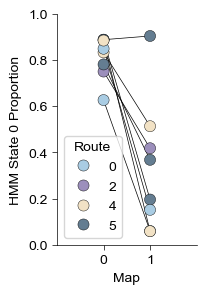

  Mean: 0.8120870273735399, STD: 0.08496437008389258, Max: 0.8875892950119754, Min: 0.6262017786639158, Median: 0.8405510653747815, df: 7
  Mean: 0.3332792176485101, STD: 0.2666038373168474, Max: 0.9036144578313253, Min: 0.05841974587410545, Median: 0.2815303423669136, df: 7
TtestResult(statistic=4.981661900495174, pvalue=0.0015979832571179017, df=7)
Seg1: LinregressResult(slope=0.009534070702696627, intercept=-0.3711153793652631, rvalue=0.05156976328699451, pvalue=0.7058317266891179, stderr=0.02512511689337918, intercept_stderr=0.09058989726110511)
Seg2: LinregressResult(slope=-0.043122889717440396, intercept=-0.014727543301039814, rvalue=-0.37918868922002713, pvalue=0.002001534096670995, stderr=0.013364363836709813, intercept_stderr=0.14362805609551024)
Seg3: LinregressResult(slope=0.007923393997996561, intercept=-0.7306569288626936, rvalue=0.06772252573564722, pvalue=0.594924627733753, stderr=0.014824636679020418, intercept_stderr=0.2763512688609783)


C:\Users\12454\AppData\Local\Temp\ipykernel_5692\3578694818.py:272: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.lineplot(
C:\Users\12454\AppData\Local\Temp\ipykernel_5692\3578694818.py:286: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.lineplot(
C:\Users\12454\AppData\Local\Temp\ipykernel_5692\3578694818.py:300: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.lineplot(


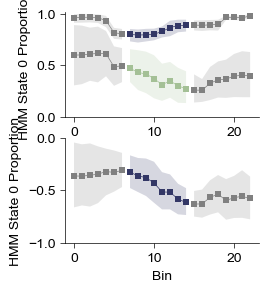

In [8]:
if exists(join(figdata, f"{code_id} [HMM For Map Swing Analysis].pkl")) == False:
    PFMSProb = {
        'MiceID': [],
        'Session': [],
        'Route': [],
        'HMM State 0 Proportion': [],
        'Map': []
    }
    
    PFMSProbBin = {
        'MiceID': [],
        'Session': [],
        'Route': [],
        'HMM State 0 Proportion': [],
        'Map': [],
        'Bin': []
    }
    
    pre_final_segment_bins = np.array([97, 109, 110, 122, 123, 111, 112, 100])
    pre_final_segment_bins2 = np.array([39, 38, 37, 49, 61, 73, 85, 97, 109, 110, 122, 123, 111, 112, 100, 99, 87, 88, 76, 77, 89, 101, 102])
    session_dict = {
        10212: [2],
        10224: [],
        10227: [1],
        10232: [0, 2, 4]
    }
    _LENGTH = len(pre_final_segment_bins2)
    
    for mouse in [10212, 10224, 10227, 10232]:
        with open(join(dir_name4, f"{mouse}.pkl"), "rb") as f:
            X, session_label, route_label, kmeans_init = pickle.load(f)
    
        kmeans_init = np.vstack([np.mean(i, axis=0) for i in kmeans_init])
        U, V = fit_kmeans(X, 2, kmeans_init=kmeans_init)
        D = get_lap_distances(X, V)
        print(D.shape)
    
        for s in tqdm(session_dict[mouse]):
            (
                behav_nodes_traj,
                behav_nodes_son_traj,
                behav_lap_traj,
                behav_routes_traj,
                behav_session_traj,
                behav_params_traj,
                behav_params_templ_traj,
                behav_dt_traj,
                behav_t_traj,
                behav_res_angles,
                behav_res_speeds,
                behav_hidden_states
            ) = behavioral_template_retrieval(mouse, session=s)

            beg = np.concatenate([[0], np.where(np.diff(behav_lap_traj) != 0)[0] + 1])
            end = np.concatenate([np.where(np.diff(behav_lap_traj) != 0)[0]+1, [len(behav_lap_traj)]])
            
            routes = behav_routes_traj[beg]
            idx = np.where(np.isin(routes, [0, 1, 2, 4, 5])&(U[session_label == s, 1] == 1))[0]
            uniq_routes = np.unique(routes[idx])
            
            
            for r in uniq_routes:
                lap_indexes_0 = np.where((routes == r)&(U[session_label == s, 0] == 1))[0]
                lap_indexes_1 = np.where((routes == r)&(U[session_label == s, 1] == 1))[0]
                
                state_prob_0 = np.zeros(len(lap_indexes_0), dtype=np.float64)
                state_prob_1 = np.zeros(len(lap_indexes_1), dtype=np.float64)
                
                state_prob_0_bin = np.zeros((len(lap_indexes_0), _LENGTH, 2), dtype=np.float64)
                state_prob_1_bin = np.zeros((len(lap_indexes_1), _LENGTH, 2), dtype=np.float64)
                
                for i, j in enumerate(lap_indexes_0):
                    state0_idx = np.where(
                        (np.isin(behav_nodes_traj[beg[j]:end[j]], pre_final_segment_bins)) & 
                        (behav_hidden_states[beg[j]:end[j]] == 0)
                    )[0]
                    all_idx = np.where(
                        (np.isin(behav_nodes_traj[beg[j]:end[j]], pre_final_segment_bins))
                    )[0]

                    state_prob_0[i] = np.sum(behav_dt_traj[beg[j]:end[j]][state0_idx]) / np.sum(behav_dt_traj[beg[j]:end[j]][all_idx])
                    
                    for k, b in enumerate(pre_final_segment_bins2):
                        state0_idx_bin = np.where(
                            (behav_nodes_traj[beg[j]:end[j]] == b) & 
                            (behav_hidden_states[beg[j]:end[j]] == 0)
                        )[0]
                        all_idx_bin = np.where(behav_nodes_traj[beg[j]:end[j]] == b)[0]
                        
                        if len(all_idx_bin) > 0:
                            state_prob_0_bin[i, k, 0] = np.sum(behav_dt_traj[beg[j]:end[j]][state0_idx_bin])
                            state_prob_0_bin[i, k, 1] = np.sum(behav_dt_traj[beg[j]:end[j]][all_idx_bin])
                        else:
                            state_prob_0_bin[i, k] = 0

                for i, j in enumerate(lap_indexes_1):
                    state0_idx = np.where(
                        (np.isin(behav_nodes_traj[beg[j]:end[j]], pre_final_segment_bins)) & 
                        (behav_hidden_states[beg[j]:end[j]] == 0)
                    )[0]
                    all_idx = np.where(
                        (np.isin(behav_nodes_traj[beg[j]:end[j]], pre_final_segment_bins))
                    )[0]
                    
                    state_prob_1[i] = np.sum(behav_dt_traj[beg[j]:end[j]][state0_idx]) / np.sum(behav_dt_traj[beg[j]:end[j]][all_idx])
                    
                    for k, b in enumerate(pre_final_segment_bins2):
                        state0_idx_bin = np.where(
                            (behav_nodes_traj[beg[j]:end[j]] == b) & 
                            (behav_hidden_states[beg[j]:end[j]] == 0)
                        )[0]
                        all_idx_bin = np.where(behav_nodes_traj[beg[j]:end[j]] == b)[0]
                        
                        if len(all_idx_bin) > 0:
                            state_prob_1_bin[i, k, 0] = np.sum(behav_dt_traj[beg[j]:end[j]][state0_idx_bin])
                            state_prob_1_bin[i, k, 1] = np.sum(behav_dt_traj[beg[j]:end[j]][all_idx_bin])
                        else:
                            state_prob_1_bin[i, k] = 0
                
                for i in range(state_prob_0_bin.shape[0]):
                    state_prob_0_bin[i, :, 0] = np.convolve(state_prob_0_bin[i, :, 0], np.ones(7), mode='same') / np.convolve(state_prob_0_bin[i, :, 1], np.ones(7), mode='same')
                for i in range(state_prob_1_bin.shape[0]):
                    state_prob_1_bin[i, :, 0] = np.convolve(state_prob_1_bin[i, :, 0], np.ones(7), mode='same') / np.convolve(state_prob_1_bin[i, :, 1], np.ones(7), mode='same')
                    
                if state_prob_1.shape[0] == 1:
                    PFMSProb['MiceID'] += [mouse, mouse]
                    PFMSProb['Session'] += [s, s]
                    PFMSProb['Route'] += [r, r]
                    PFMSProb['HMM State 0 Proportion'] += [np.mean(state_prob_0), np.mean(state_prob_1)]
                    PFMSProb['Map'] += [0, 1]
                    
                    PFMSProbBin['MiceID'].append(np.repeat(mouse, _LENGTH*2))
                    PFMSProbBin['Session'].append(np.repeat(s, _LENGTH*2))
                    PFMSProbBin['Route'].append(np.repeat(r, _LENGTH*2))
                    PFMSProbBin['HMM State 0 Proportion'].append(np.concatenate([np.mean(state_prob_0_bin[:, :, 0], axis=0), np.mean(state_prob_1_bin[:, :, 0], axis=0)]))
                    PFMSProbBin['Map'].append(np.concatenate([np.repeat(0, _LENGTH), np.repeat(1, _LENGTH)]))
                    PFMSProbBin['Bin'].append(np.concatenate([np.arange(_LENGTH), np.arange(_LENGTH)]))
                else:
                    for d in range(state_prob_1.shape[0]):
                        PFMSProb['MiceID'] += [mouse, mouse]
                        PFMSProb['Session'] += [s, s]
                        PFMSProb['Route'] += [r, r]
                        PFMSProb['HMM State 0 Proportion'] += [np.mean(state_prob_0), state_prob_1[d]]
                        PFMSProb['Map'] += [0, 1]
                        
                        PFMSProbBin['MiceID'].append(np.repeat(mouse, _LENGTH*2))
                        PFMSProbBin['Session'].append(np.repeat(s, _LENGTH*2))
                        PFMSProbBin['Route'].append(np.repeat(r, _LENGTH*2))
                        PFMSProbBin['HMM State 0 Proportion'].append(np.concatenate([np.mean(state_prob_0_bin[:, :, 0], axis=0), np.mean(state_prob_1_bin[d:d+1, :, 0], axis=0)]))
                        PFMSProbBin['Map'].append(np.concatenate([np.repeat(0, _LENGTH), np.repeat(1, _LENGTH)]))
                        PFMSProbBin['Bin'].append(np.concatenate([np.arange(_LENGTH), np.arange(_LENGTH)]))
                        

    for k in PFMSProb.keys():
        dtype = np.float64 if k in ['HMM State 0 Proportion'] else np.int64
        PFMSProb[k] = np.array(PFMSProb[k], dtype=dtype)
        
    for k in PFMSProbBin.keys():
        dtype = np.float64 if k in ['HMM State 0 Proportion'] else np.int64
        PFMSProbBin[k] = np.concatenate(PFMSProbBin[k], dtype=dtype)

    with open(join(figdata, f"{code_id} [HMM For Map Swing Analysis].pkl"), 'wb') as f:
        pickle.dump(PFMSProb, f)
        
    with open(join(figdata, f"{code_id} [HMM For Map Swing Analysis Bin].pkl"), 'wb') as f:
        pickle.dump(PFMSProbBin, f)

    PFMSProbD = pd.DataFrame(PFMSProb)
    PFMSProbD.to_excel(join(figdata, f"{code_id} [HMM For Map Swing Analysis].xlsx"), index=False)
    
    PFMSProbBinD = pd.DataFrame(PFMSProbBin)
    PFMSProbBinD.to_excel(join(figdata, f"{code_id} [HMM For Map Swing Analysis Bin].xlsx"), index=False)
    print(len(PFMSProbD), len(PFMSProbBinD))
else:
    with open(join(figdata, f"{code_id} [HMM For Map Swing Analysis].pkl"), 'rb') as f:
        PFMSProb = pickle.load(f)
        
    with open(join(figdata, f"{code_id} [HMM For Map Swing Analysis Bin].pkl"), 'rb') as f:
        PFMSProbBin = pickle.load(f)
        
fig = plt.figure(figsize=(1.8, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.stripplot(
    x='Map',
    y='HMM State 0 Proportion',
    hue='Route',
    data=PFMSProb,
    palette=[DSPPalette[r] for r in np.unique(PFMSProb['Route'])],
    ax=ax,
    size=8,
    linewidth=0.3,
    edgecolor='k',
    jitter=0,
    zorder=2
)
ax.set_ylim(0, 1)
idx0 = np.where(PFMSProb['Map'] == 0)[0]
idx1 = np.where(PFMSProb['Map'] == 1)[0]
for i in range(len(idx0)):
    ax.plot(
        [0, 1], 
        [PFMSProb['HMM State 0 Proportion'][idx0[i]], PFMSProb['HMM State 0 Proportion'][idx1[i]]], 
        color='k', linewidth=0.5,
        zorder=1
    )
ax.set_xlim(-1, 2)
plt.savefig(join(loc, f"HMM For Map Swing Analysis.png"), dpi=600)
plt.savefig(join(loc, f"HMM For Map Swing Analysis.svg"), dpi=600)
plt.show()

print_estimator(PFMSProb['HMM State 0 Proportion'][idx0])
print_estimator(PFMSProb['HMM State 0 Proportion'][idx1])
print(ttest_rel(PFMSProb['HMM State 0 Proportion'][idx0], PFMSProb['HMM State 0 Proportion'][idx1]))

fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(2.5, 3))
ax0 = Clear_Axes(axes[0], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
ax1 = Clear_Axes(axes[1], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
SubData = SubDict(PFMSProbBin, PFMSProbBin.keys(), np.where((PFMSProbBin['Bin'] <= 6))[0])
SubData2 = SubDict(PFMSProbBin, PFMSProbBin.keys(), np.where((PFMSProbBin['Bin'] >= 7)&(PFMSProbBin['Bin'] <= 14))[0])
SubData3 = SubDict(PFMSProbBin, PFMSProbBin.keys(), np.where((PFMSProbBin['Bin'] >= 15))[0])
sns.lineplot(
    x='Bin',
    y='HMM State 0 Proportion',
    data=SubData,
    palette=['gray', 'gray'],
    marker='s',
    markersize=5,
    markeredgewidth=0,
    hue='Map',
    linewidth=0.5,
    err_kws={'edgecolor':None},
    legend=False,
    ax=ax0
)
sns.lineplot(
    x='Bin',
    y='HMM State 0 Proportion',
    data=SubData2,
    palette=RemappingPalette,
    hue='Map',
    linewidth=0.5,
    marker='s',
    markersize=5,
    markeredgewidth=0,
    err_kws={'edgecolor':None},
    legend=False,
    ax=ax0
)
sns.lineplot(
    x='Bin',
    y='HMM State 0 Proportion',
    data=SubData3,
    palette=['gray', 'gray'],
    marker='s',
    markersize=5,
    markeredgewidth=0,
    hue='Map',
    linewidth=0.5,
    err_kws={'edgecolor':None},
    legend=False,
    ax=ax0
)
# Get residual of the linear_fit
ResData = SubDict(PFMSProbBin, PFMSProbBin.keys(), np.where(PFMSProbBin['Map'] == 1)[0])
ResData['HMM State 0 Proportion'] -= PFMSProbBin['HMM State 0 Proportion'][PFMSProbBin['Map'] == 0]
SubData = SubDict(ResData, ResData.keys(), np.where((ResData['Bin'] <= 6))[0])
print(f"Seg1: {linregress(SubData['Bin'], SubData['HMM State 0 Proportion'])}")
SubData2 = SubDict(ResData, ResData.keys(), np.where((ResData['Bin'] >= 7)&(ResData['Bin'] <= 14))[0])
print(f"Seg2: {linregress(SubData2['Bin'], SubData2['HMM State 0 Proportion'])}")
SubData3 = SubDict(ResData, ResData.keys(), np.where((ResData['Bin'] >= 15))[0])
print(f"Seg3: {linregress(SubData3['Bin'], SubData3['HMM State 0 Proportion'])}")
sns.lineplot(
    x='Bin',
    y='HMM State 0 Proportion',
    data=SubData,
    palette=['gray', 'gray'],
    marker='s',
    markersize=5,
    markeredgewidth=0,
    hue='Map',
    linewidth=0.5,
    err_kws={'edgecolor':None},
    legend=False,
    ax=ax1
)
sns.lineplot(
    x='Bin',
    y='HMM State 0 Proportion',
    data=SubData2,
    palette=RemappingPalette,
    hue='Map',
    linewidth=0.5,
    marker='s',
    markersize=5,
    markeredgewidth=0,
    err_kws={'edgecolor':None},
    legend=False,
    ax=ax1
)
sns.lineplot(
    x='Bin',
    y='HMM State 0 Proportion',
    data=SubData3,
    palette=['gray', 'gray'],
    marker='s',
    markersize=5,
    markeredgewidth=0,
    hue='Map',
    linewidth=0.5,
    err_kws={'edgecolor':None},
    legend=False,
    ax=ax1
)
ax0.set_ylim(0, 1.02)
ax1.set_ylim(-1, 0)
plt.savefig(join(loc, f"HMM For Map Swing Analysis Bin.png"), dpi=600)
plt.savefig(join(loc, f"HMM For Map Swing Analysis Bin.svg"), dpi=600)
plt.show()

Before Transition: Ttest_indResult(statistic=3.6645921154224053, pvalue=0.0004741840626030357)
After Transition: Ttest_indResult(statistic=nan, pvalue=nan)


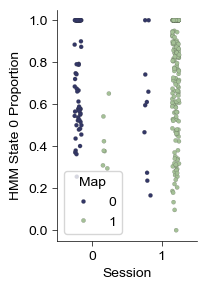

In [ ]:
if exists(join(figdata, f"{code_id} [HMM For Map Swing Analysis R7].pkl")) == False:
    PFMSProbR7 = {
        'MiceID': [],
        'Session': [],
        'HMM State 0 Proportion': [],
        'Map': []
    }
    
    pre_final_segment_bins = np.array([109, 110, 122, 123, 111, 112, 100])
    session_dict = {
        10212: [0, 2, 3, 4, 5],
        10224: [0],
        10227: [1, 3, 4, 5],
        10232: [0, 3]
    }
    
    session_convertor = {
        10212: np.arange(-5, 2),
        10224: np.arange(0, 7),
        10227: np.arange(-3, 4),
        10232: np.arange(-1, 6)
    }
    
    for mouse in [10212, 10224, 10227, 10232]:
        with open(join(dir_name4, f"{mouse}.pkl"), "rb") as f:
            X, session_label, route_label, kmeans_init = pickle.load(f)
    
        kmeans_init = np.vstack([np.mean(i, axis=0) for i in kmeans_init])
        U, V = fit_kmeans(X, 2, kmeans_init=kmeans_init)
        D = get_lap_distances(X, V)
        print(D.shape)
    
        for s in tqdm(range(7)):
            (
                behav_nodes_traj,
                behav_nodes_son_traj,
                behav_lap_traj,
                behav_routes_traj,
                behav_session_traj,
                behav_params_traj,
                behav_params_templ_traj,
                behav_dt_traj,
                behav_t_traj,
                behav_res_angles,
                behav_res_speeds,
                behav_hidden_states
            ) = behavioral_template_retrieval(mouse, session=s)

            beg = np.concatenate([[0], np.where(np.diff(behav_lap_traj) != 0)[0] + 1])
            end = np.concatenate([np.where(np.diff(behav_lap_traj) != 0)[0]+1, [len(behav_lap_traj)]])
            
            routes = behav_routes_traj[beg]
            r = 6
            
            lap_indexes_0 = np.where((routes == r)&(U[session_label == s, 0] == 1))[0]
            lap_indexes_1 = np.where((routes == r)&(U[session_label == s, 1] == 1))[0]
                
            state_prob_0 = np.zeros(len(lap_indexes_0), dtype=np.float64)
            state_prob_1 = np.zeros(len(lap_indexes_1), dtype=np.float64)
                
            for i, j in enumerate(lap_indexes_0):
                state0_idx = np.where(
                    (np.isin(behav_nodes_traj[beg[j]:end[j]], pre_final_segment_bins)) & 
                    (behav_hidden_states[beg[j]:end[j]] == 0)
                )[0]
                all_idx = np.where(
                    (np.isin(behav_nodes_traj[beg[j]:end[j]], pre_final_segment_bins))
                )[0]

                state_prob_0[i] = np.nansum(behav_dt_traj[beg[j]:end[j]][state0_idx]) / np.nansum(behav_dt_traj[beg[j]:end[j]][all_idx])

            for i, j in enumerate(lap_indexes_1):
                state0_idx = np.where(
                    (np.isin(behav_nodes_traj[beg[j]:end[j]], pre_final_segment_bins)) & 
                    (behav_hidden_states[beg[j]:end[j]] == 0)
                )[0]
                all_idx = np.where(
                    (np.isin(behav_nodes_traj[beg[j]:end[j]], pre_final_segment_bins))
                )[0]
                    
                state_prob_1[i] = np.nansum(behav_dt_traj[beg[j]:end[j]][state0_idx]) / np.nansum(behav_dt_traj[beg[j]:end[j]][all_idx])
    
            _length = state_prob_0.shape[0] + state_prob_1.shape[0]
            PFMSProbR7['MiceID'].append(np.repeat(mouse, _length))
            PFMSProbR7['Session'].append(np.repeat(session_convertor[mouse][s], _length))
            PFMSProbR7['HMM State 0 Proportion'].append(np.concatenate([state_prob_0, state_prob_1]))
            PFMSProbR7['Map'].append(np.concatenate([np.repeat(0, state_prob_0.shape[0]), np.repeat(1, state_prob_1.shape[0])]))

    for k in PFMSProbR7.keys():
        dtype = np.float64 if k in ['HMM State 0 Proportion'] else np.int64
        PFMSProbR7[k] = np.concatenate(PFMSProbR7[k], dtype=dtype)

    with open(join(figdata, f"{code_id} [HMM For Map Swing Analysis R7].pkl"), 'wb') as f:
        pickle.dump(PFMSProbR7, f)

    PFMSProbR7D = pd.DataFrame(PFMSProbR7)
    PFMSProbR7D.to_excel(join(figdata, f"{code_id} [HMM For Map Swing Analysis R7].xlsx"), index=False)
    print(len(PFMSProbR7D))
else:
    with open(join(figdata, f"{code_id} [HMM For Map Swing Analysis R7].pkl"), 'rb') as f:
        PFMSProbR7 = pickle.load(f)
        
fig = plt.figure(figsize=(1.8, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
PFMSProbR7['Session'] = np.where(PFMSProbR7['Session'] >= 0, 1, 0)
sns.stripplot(
    x='Session',
    y='HMM State 0 Proportion',
    hue='Map',
    data=PFMSProbR7,
    palette=RemappingPalette,
    ax=ax,
    size=3,
    linewidth=0.1,
    dodge=True
)

bef_m0 = PFMSProbR7['HMM State 0 Proportion'][(PFMSProbR7['Session'] == 0)&(PFMSProbR7['Map'] == 0)]
bef_m1 = PFMSProbR7['HMM State 0 Proportion'][(PFMSProbR7['Session'] == 0)&(PFMSProbR7['Map'] == 1)]
aft_m0 = PFMSProbR7['HMM State 0 Proportion'][(PFMSProbR7['Session'] == 1)&(PFMSProbR7['Map'] == 0)]
aft_m1 = PFMSProbR7['HMM State 0 Proportion'][(PFMSProbR7['Session'] == 1)&(PFMSProbR7['Map'] == 1)]

print(f"Before Transition: {ttest_ind(bef_m0, bef_m1)}")
print(f"After Transition: {ttest_ind(aft_m0, aft_m1)}") 